In [10]:
from copy import deepcopy
from time import time
from itertools import zip_longest

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize, root_scalar, differential_evolution

from sklearn.cluster import DBSCAN, KMeans, MeanShift
from sklearn.neighbors import NearestNeighbors as nn
from sklearn.metrics import pairwise_distances, calinski_harabaz_score, silhouette_score
from sklearn.metrics.pairwise import paired_distances

import sklearn

### DBSCAN

In [2]:
def reader(file_name, skip_lines=0, commos2points=False):
    '''
    read only 3 coords
    return np.array

    '''

    list_obj = list()
    with open(file_name, 'r') as fd_file:
        for line in fd_file:
            if skip_lines:
                skip_lines -= 1
                continue
            if commos2points:
                line = line.replace(',', '.')
            line = line.split()
            coords = np.zeros(shape=(3,))
            coords[0] = float(line[0])
            coords[1] = float(line[1])
            coords[2] = float(line[2])
            list_obj.append(coords)
    return np.array(list_obj)

def get_cone(array, ra, dec, offset=1.5):
    mask = ((array[:,0] > ra - offset) & (array[:, 0] < ra + offset) &
            (array[:,1] > dec - offset) & (array[:,1] < dec + offset))
    return array[mask]


def left_right_regions(points_ra_dec):
    array = points_ra_dec
    mask_right = (((array[:,0] < 60) | (array[:,0] > 306)) &
                  (array[:, 1] > -12) & (array[:, 1] < 37))
    mask_left = ((array[:,0] > 102) & (array[:,0] < 270) & 
                 (array[:,1] > -4) & (array[:,1] < 69))
    
    return array[mask_left], array[mask_right]

def do_scan(points_xyz, n_neighbors, eps, verbose=False):
    num_clusters_inter = 4
    
    dbscan = DBSCAN(eps=eps, min_samples=n_neighbors+1).fit(points_xyz)
    cen_dbscan = points_xyz[dbscan.labels_==0].mean(axis=0)

    clusters = list()
    cen_clusters = list()

    labels, count_labels = np.unique(dbscan.labels_, return_counts=True)
    most_freq_labels = labels[np.argsort(count_labels)[::-1][:num_clusters_inter]]

    for lab in most_freq_labels:
        if lab == -1:
            continue
        clusters.append(points_xyz[dbscan.labels_==lab])    
        cen_clusters.append(clusters[-1].mean(axis=0))
        if verbose:
            print('for label', lab, 'there are', clusters[-1].shape[0], 'galaxies')
    
    noize = points_xyz[dbscan.labels_==-1]
    if verbose:
        print('noize num : ', noize.shape)

    return clusters, cen_clusters, noize, dbscan.labels_


def to_ra_dec_redshift(points_xyz):
    if points_xyz.shape == (3,):
        points_xyz = points_xyz.reshape((1,3)) 
    redshift = np.linalg.norm(points_xyz, axis=1)
    ra = np.arctan(points_xyz[:,1]/points_xyz[:,0]) * 180.0 / np.pi
    dec = (90.0 - np.arccos(
        points_xyz[:,2]/np.linalg.norm(points_xyz, axis=1)) * 180.0 / np.pi)
    
    mask_2_3 = (points_xyz[:,0] < 0)
    mask_4 = ((points_xyz[:,0] > 0) & (points_xyz[:,1] < 0))
    
    ra[mask_2_3] = 180 + ra[mask_2_3]
    ra[mask_4] = 360 + ra[mask_4]
    
    points_sphere = np.zeros_like(points_xyz)
    points_sphere[:,0] = ra
    points_sphere[:,1] = dec
    points_sphere[:,2] = redshift
    

    return points_sphere


def to_xyz(polar_points):
    points = polar_points
    if points.shape == (3,):
        points = points.reshape((1,3))
    cos_dec = np.cos(points[:,1]*np.pi/180.0)
    sin_dec = np.sin(points[:,1]*np.pi/180.0)
    
    cos_ra = np.cos(points[:,0]*np.pi/180.0)
    sin_ra = np.sin(points[:,0]*np.pi/180.0)
    
    r = points[:,2]
    points_xyz = np.zeros_like(points)
    points_xyz[:,0] = r * cos_dec * cos_ra
    points_xyz[:,1] = r * cos_dec * sin_ra
    points_xyz[:,2] = r * sin_dec 
    return points_xyz

def func_distr(points, n_neighbors):
    #calculate dist to n_neighbor and indecies
    nbrs = nn(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(points)
    dist, ind = nbrs.kneighbors(points)
    dist_to_nneighbor = dist[:,n_neighbors]   
    return dist, ind

def shuffle_coords(arr_clusters):
    list_coords_shuffled = list()
    for coord in arr_clusters.T:
        coord_to_shuffle = deepcopy(coord)
        np.random.shuffle(coord_to_shuffle)
        list_coords_shuffled.append(coord_to_shuffle)
    
    arr_clusters_shuffled = np.array(list_coords_shuffled).T
    return arr_clusters_shuffled


def get_hist(arr_clusters, num_bins, right_edge):
    pair_dist_clusters = pairwise_distances(arr_clusters)
    not_zero_pair = np.triu(pair_dist_clusters)
    not_zero_pair = not_zero_pair[not_zero_pair!=0]
    arr_clusters.shape

    #to_del = np.unique(np.argwhere((pair_dist_clusters<2) & (pair_dist_clusters>0)).flatten())
    #arr_clusters = np.delete(arr_clusters, to_del, 0)

    n1 = np.histogram(not_zero_pair, num_bins, [0, right_edge])
    return n1


        
    


In [3]:
class distr_red_shift(stats.rv_continuous):
    max_prob_distr = 1.02
    max_val_distr = 0.3
    
    def __init__(self, min_val=0., max_val=max_val_distr):
        super().__init__()
        self.min_val = min_val
        self.max_val = max_val
    
    def _rvs(self):
        size = self._size[0]
        min_prob = self.cdf(self.min_val)
        max_prob = self.cdf(self.max_val)
        
        list_values = list()
        i = 0
        while i < size-1:
            prob = np.random.rand() * (max_prob - min_prob) + min_prob
            sol_eq = root_scalar(
                self.__make_equation_cdf, args=prob, bracket=[0, 0.3], method='brentq')
            if(sol_eq.converged):
                list_values.append(sol_eq.root)
                i+=1
        return np.array(list_values)        
    
    
    def _pdf(self, x):
        res = np.zeros_like(x)
        res[x <= 0.075] = 93.*x[x <= 0.075]
        res[(0.075 < x) & (x <= 0.09)] = 7
        res[(0.09 < x) & (x <= 0.14)]  = 5.8
        res[(0.14 < x) & (x <= 0.21)] = -50.*x[(0.14 < x) & (x <= 0.21)] + 12.
        res[(0.21 < x) & (x <= 0.3)] = 1.5
        return res
    
    def _cdf(self, x):
        res = np.zeros_like(x)
        res[x <= 0.075] = 46.5*x[x <= 0.075]**2
        res[(0.075 < x) & (x <= 0.09)] = 7.*x[(0.075 < x) & (x <= 0.09)] - 0.2625 
        res[(0.09 < x) & (x <= 0.14)] = 5.8*x[(0.09 < x) & (x <= 0.14)] - 0.1545 #0.522 + (0.2625 + 0.105)
        res[(0.14 < x) & (x <= 0.21)] = (-25.*x[(0.14 < x) & (x <= 0.21)]**2 
                                         + 12.*x[(0.14 < x) & (x <= 0.21)] - 0.5325)
        res[(0.21 < x) & (x <= 0.3)] = 1.5*x[(0.21 < x) & (x <= 0.3)] + 0.57
        res[x >= 0.3] = 1.02
        return res
    
    def __cdf_for_one(self, x):
        if x < 0:
            res = 0
        if x <= 0.075:
            res = 46.5*x**2
        if 0.075 < x <= 0.09:
            res = 7.*x - 0.2625 
        if 0.09 < x <= 0.14:
            res = 5.8 * x - 0.522 + (0.2625 + 0.105)
        if 0.14 < x <= 0.21:
            res = -25.*x**2 + 12.*x - 0.5325
        if 0.21 < x <= 0.3:
            res =  1.5*x + 0.57
        if x > 0.3:
            res = 1.02
        return res    
    
    def __make_equation_cdf(self, x, y):
        return self.__cdf_for_one(x) - y
    


In [4]:
def plot_distinguish(n1, n2):
    distinguish = n1[0] - n2[0]
    plt.errorbar(n2[1][1:], 
             np.zeros_like(n2[1][1:]), 
             yerr=[np.zeros_like(distinguish), distinguish], alpha=1)
    
def uniform_distr(points_xyz, in_polar):
    if in_polar:
        points = to_ra_dec_redshift(points_xyz)
    else:
        points = points_xyz
    new_coords = np.zeros_like(points)
    
    for i, coord in enumerate(points.T):
        max_ = np.max(coord)
        min_ = np.min(coord)
        if i==2 and in_polar:
            new_coords[:,i] = distr_red_shift(min_val=min_, max_val=max_).rvs(size=coord.shape[0]+1)
            continue   
        new_coord = np.random.rand(*coord.shape)*(max_ - min_) + min_
        new_coords[:,i] = new_coord
    if in_polar:
        return to_xyz(new_coords)
    return new_coords
        
def plot_results(array_clusters_xyz, 
                 num_bins, right_edge, 
                 mod_mix, 
                 save=False, name='all_diagrams'):
    '''
    mod_mix:
    1: mix red_shift
    2: mix all polar coords
    3: mix all xyz coords
    4: uniform polar coords
    5: uniform xyz coords
    '''
    
    mix_array_clusters_xyz = None
    mix_array_clusters_polar = None
    array_clusters_polar = to_ra_dec_redshift(array_clusters_xyz)
    
    
    if mod_mix==1:
        array_clusters_polar_mix = deepcopy(array_clusters_polar)
        array_clusters_polar_mix[:,2] = shuffle_coords(
            array_clusters_polar_mix[:,2].reshape(-1, 1)).reshape(-1,)

        mix_array_clusters_xyz = to_xyz(array_clusters_polar_mix)
    elif mod_mix==2:
        mix_array_clusters_xyz = to_xyz(shuffle_coords(array_clusters_polar))
    elif mod_mix==3:
        mix_array_clusters_xyz = shuffle_coords(array_clusters_xyz)
    elif mod_mix==4:
        mix_array_clusters_xyz = uniform_distr(array_clusters_xyz, in_polar=True)
    elif mod_mix==5:
        mix_array_clusters_xyz = uniform_distr(array_clusters_xyz, in_polar=False)
    
    mix_array_clusters_polar = to_ra_dec_redshift(mix_array_clusters_xyz)
    
    n1 = get_hist(array_clusters_xyz, num_bins, right_edge)           
    n2 = get_hist(mix_array_clusters_xyz, num_bins, right_edge)
    fig = plt.figure(figsize=(8, 20))
    plt.subplot(511)
    plt.scatter(n1[1][1:], n1[0], s=2)
    plt.scatter(n2[1][1:], n2[0], s=2, alpha=0.8)
    plt.xlim([0, right_edge])
    plt.xticks(np.linspace(0, right_edge, 11))
    num_bao = round(right_edge/0.035)
    plt.xticks(np.linspace(0, num_bao*0.035, num_bao+1))
    plt.grid(True)
    
    plt.subplot(512)
    plot_distinguish(n1, n2)
    plt.xlim([0, right_edge])
    plt.xticks(np.linspace(0, num_bao*0.035, num_bao+1))
    plt.grid(True)
    
    num_bins = 50
    plt.subplot(513)
    plt.title('ra')
    plt.hist(array_clusters_polar[:,0], num_bins)
    plt.hist(mix_array_clusters_polar[:,0], num_bins, alpha=0.8)
    plt.grid(True)
    
    plt.subplot(514)
    plt.title('dec')
    plt.hist(array_clusters_polar[:,1], num_bins)
    plt.hist(mix_array_clusters_polar[:,1], num_bins, alpha=0.8)
    plt.grid(True)
    
    plt.subplot(515)
    plt.title('redshift')
    plt.hist(array_clusters_polar[:,2], num_bins)
    plt.hist(mix_array_clusters_polar[:,2], num_bins, alpha=0.8)
    plt.grid(True)
    
    if save:
        name = name + '.png'
        fig.savefig(name)

In [91]:
list_c = list()
with open('data/Abell clusters (ra, dec).txt', 'r') as fd:
    for line in fd:
        line = line.split()
        ra =float(line[0])
        dec = float(line[1])
        list_c.append([ra, dec])
        
abell_clusters_ray = np.array(list_c)
left_abell, right_abell = left_right_regions(abell_clusters_ray)


In [99]:
pred = 0
for ra_ray in abell_clusters_ray[:,0]:
    if 174 < ra_ray < 198:
        if (ra_ray-pred >= 0.425):
            print(ra_ray, pred, ra_ray-pred)
        pred = ra_ray

174.025 0 174.025
186.65 186.225 0.425
189.175 188.175 1.0
189.95 189.25 0.7
191.4 190.675 0.725
194.375 193.95 0.425
196.3 195.875 0.425
196.7 196.25 0.45
197.3 196.55 0.75
197.675 197.2 0.475
197.875 197.45 0.425


In [5]:
all_gal = reader('data/0_03_Space.txt')
all_gal = all_gal[all_gal[:,2]>10e-4]
left_area, right_area = left_right_regions(all_gal)

In [9]:
left_area.shape

(751945, 3)

In [10]:
robert_cl = reader('data/Robert_Clusters_Centers_0_360_0_07.txt')

In [43]:
threshold_cone_with_cluster = 120
abell_ray = left_abell
area = left_area

list_cones = list()
list_no_clusters = list()
no_cluster_here = 0
for ra_dec in abell_ray:
    ra, dec = ra_dec[0], ra_dec[1]
    cone_with_cluster = (get_cone(area, ra, dec))
    if cone_with_cluster.shape[0] < threshold_cone_with_cluster:
        no_cluster_here += 1
        list_no_clusters.append(ra_dec)
    else:
        list_cones.append(cone_with_cluster)


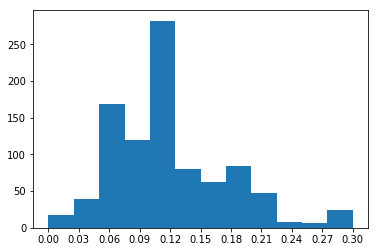

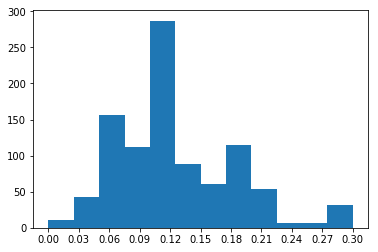

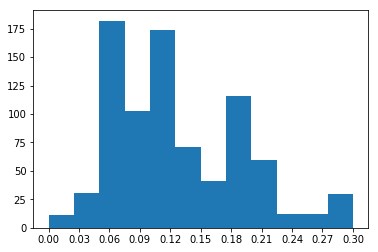

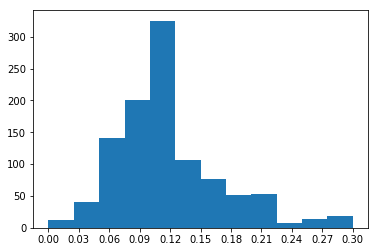

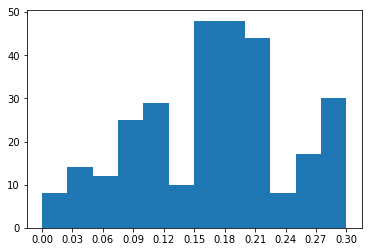

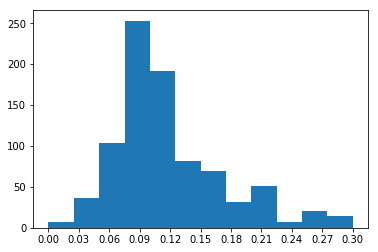

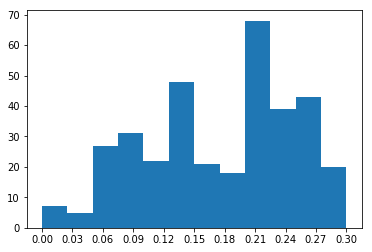

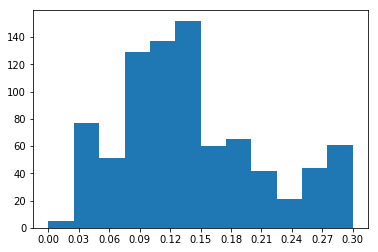

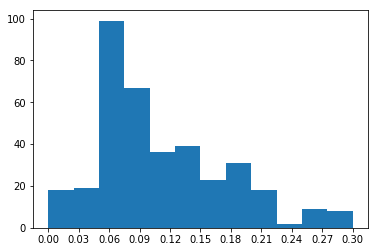

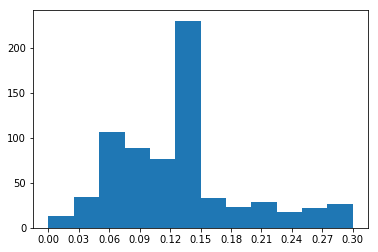

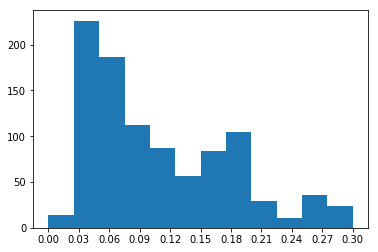

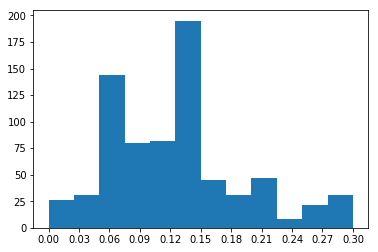

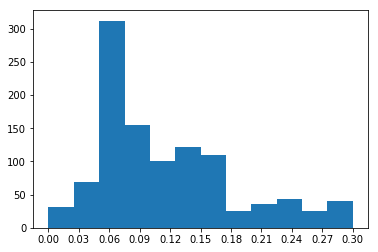

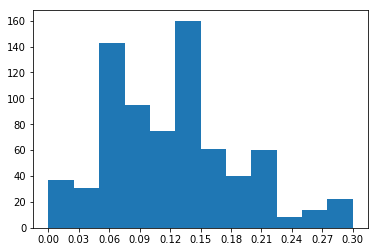

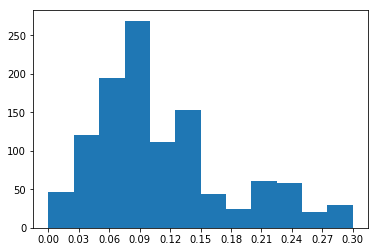

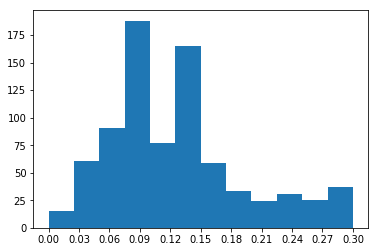

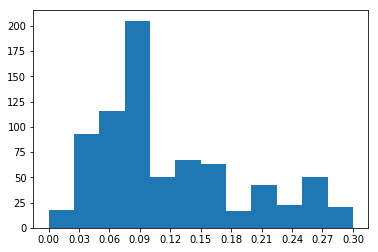

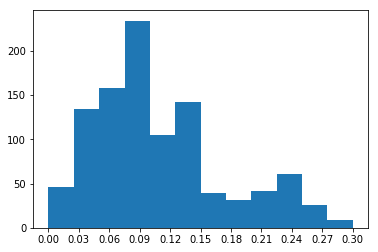

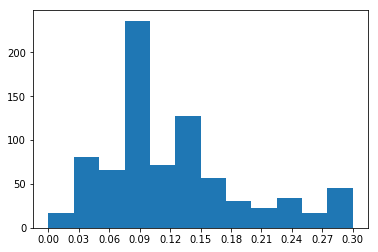

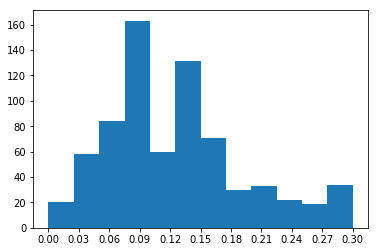

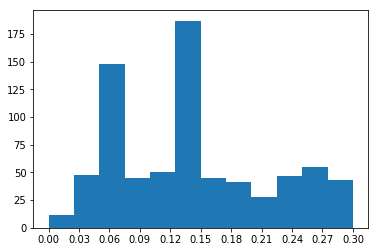

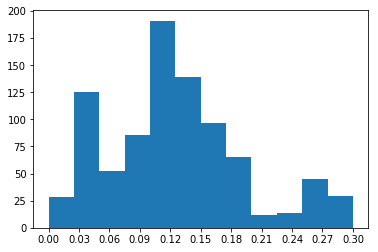

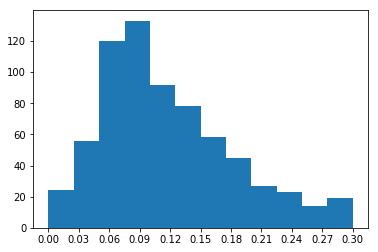

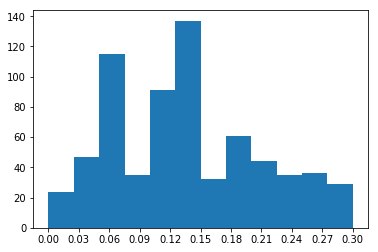

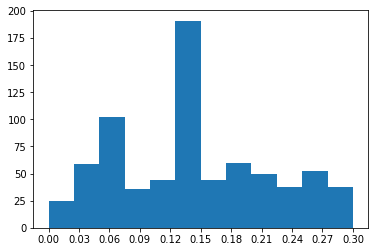

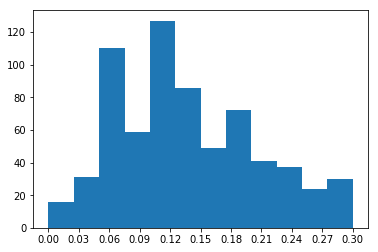

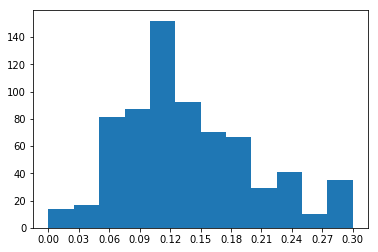

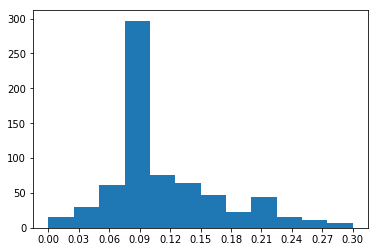

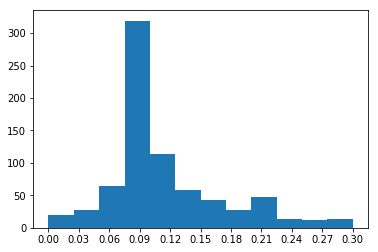

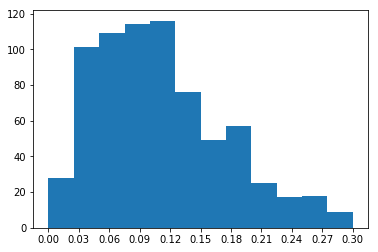

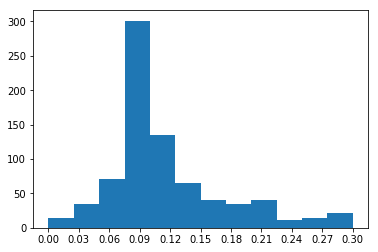

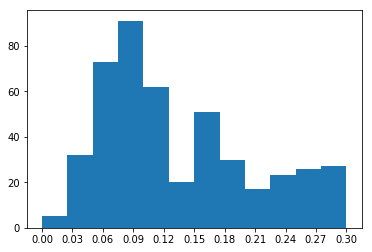

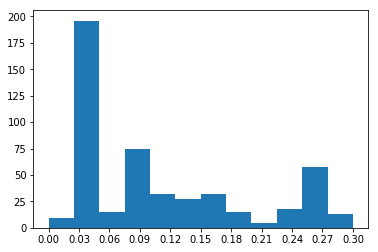

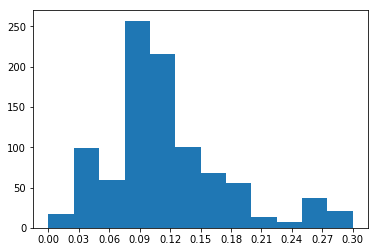

KeyboardInterrupt: 

In [44]:
for cone in list_cones:
    plt.hist(cone[:,2], 12, [0, 0.3])
    plt.xticks(np.linspace(0, 0.3, 11))
    plt.show()
    

In [ ]:
k_means = KMeans(n_clusters=1300, algorithm='elkan', verbose=2)
res_k_means = k_means.fit_predict(to_xyz(left_area))

In [ ]:
mean_shift = MeanShift(cluster_all=False)
res_mean_shift = mean_shift.fit_predict(to_xyz(left_area))

In [45]:
def analyze_seria(list_cones, verbose=False):
    '''
    seria of less chosen files
    
    '''
    coef_hugest_cluster = 0.4
    coef_2_clusters = 0.3
    coef_1st_to_2nd = 0.25
    many_galaxies = 500

    all_clusters = list()
    not_big = 0
    two_small = 0
    not_big_70 = 0
    bad_alg = 0
    two_clusters = 0
    bad_cluster = 0 
    
    all_clusters = list()
    
    for cone in list_cones:
        points_xyz = to_xyz(cone)
        num_galaxies = points_xyz.shape[0]
        pair_dist = pairwise_distances(points_xyz)
        not_zero_pair = np.triu(pair_dist)
        med = np.median(not_zero_pair[not_zero_pair!=0])
        
        if num_galaxies > many_galaxies:
            clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med*0.2)
        else:
            clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=3, eps=med*0.3)
        
        num_bigest = clusters[0].shape[0]
        if len(clusters) == 1:
            num_second = 0
        else:
            num_second = clusters[1].shape[0]
        
        if num_galaxies > many_galaxies:
            if (num_bigest-num_second)/num_bigest < coef_1st_to_2nd:
                if num_bigest > coef_2_clusters:
                    all_clusters.append(cen_clusters[0])
                    all_clusters.append(cen_clusters[1])
                    two_clusters += 1
                else:
                     two_small += 1
            elif num_bigest/num_galaxies > coef_hugest_cluster:
                all_clusters.append(cen_clusters[0])
        
            else:
                not_big += 1
    
        elif num_bigest/num_galaxies > coef_hugest_cluster:
            all_clusters.append(cen_clusters[0])  
        else:
            not_big_70 += 1
    
    if verbose:
        print(not_big, two_small, two_clusters, not_big_70)
    arr_clusters = np.array(all_clusters)
    return arr_clusters 

In [46]:
tmp1 = analyze_seria(list_cones, True)

0 0 7 0


In [26]:
def pairwise_dist(points_xyz):
    MAX_MEM = 295000000
    #MAX_MEM = 1
    batch_size = round(MAX_MEM/points_xyz.shape[0]) - 10
    num_batches = (points_xyz.shape[0]+1)//batch_size
    print(points_xyz.shape[0], batch_size, num_batches)
    dataset_avg = 0.
    for i in range(1, num_batches):
        
        batch = points_xyz[(i-1)*batch_size : i*batch_size]
        d_avg = pairwise_distances(batch, points_xyz).mean(axis=1).sum()
        if i % 10==0:
            print(i, d_avg/batch_size)
        dataset_avg += d_avg
    return dataset_avg/points_xyz.shape[0]
        

In [33]:
def apply_dbscan(points_xyz, eps, num_neighbors):
    dbscan = DBSCAN(eps=eps, min_samples=num_neighbors).fit(points_xyz)
    uniq = np.unique(dbscan.labels_, return_counts=True)
    return [dbscan.labels_, uniq[0], uniq[1]]

In [235]:
dbscan = DBSCAN(eps=0.004, min_samples=10).fit(to_xyz(left_area))
np.unique(dbscan.labels_, return_counts=True)[1][0]

In [236]:
np.unique(dbscan.labels_, return_counts=True)[1][0]

73980

In [233]:
left_area[dbscan.labels_!=-1].shape

(680712, 3)

In [221]:
for num_neighbors in [5, 10, 15]:
    for eps in [0.005, 0.006, 0.007]:
        print('eps = ', eps, 'num neig = ', num_neighbors, ';' , i)
        start_time = time()
        dbscan = DBSCAN(eps=eps, min_samples=num_neighbors+1).fit(to_xyz(left_area))
        print(time()-start_time)
        res = np.unique(dbscan.labels_, return_counts=True)
        print(res[1][0])
        print('-------------------------------------')

eps =  0.005 num neig =  5 ; 0
57.779919385910034
15885
-------------------------------------
eps =  0.006 num neig =  5 ; 0
106.53568434715271
5720
-------------------------------------
eps =  0.007 num neig =  5 ; 0
113.45121574401855
1902
-------------------------------------
eps =  0.005 num neig =  10 ; 0
55.54366374015808
43320
-------------------------------------
eps =  0.006 num neig =  10 ; 0
73.50270676612854
19290
-------------------------------------
eps =  0.007 num neig =  10 ; 0
95.5066123008728
7360
-------------------------------------
eps =  0.005 num neig =  15 ; 0
51.69136667251587
71233
-------------------------------------
eps =  0.006 num neig =  15 ; 0
68.3248815536499
38749
-------------------------------------
eps =  0.007 num neig =  15 ; 0
92.77723169326782
17314
-------------------------------------


In [220]:
res

array([  -1,    0,    1, ..., 1168, 1169, 1170], dtype=int64)

In [20]:
left_area.shape

(751945, 3)

In [23]:
np.unique(list_l[6], return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

In [37]:
import Cluster_Ensembles as CE

In [33]:
import imp
imp.reload(CE)

<module 'Cluster_Ensembles' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Cluster_Ensembles\\__init__.py'>

In [218]:
i = 0
for num_neighbors in [5, 10, 15]:
    for eps in [0.005, 0.006, 0.007]:
        print('eps = ', eps, 'num neig = ', num_neighbors, i)
        res = np.unique(list_l[i], return_counts=True)
        print(res[1][0], '\n')
        i += 1

eps =  0.005 num neig =  5 0


NameError: name 'list_l' is not defined

In [128]:
for a in squared_func(np.array([15, 30, 100, 150, 200, 300, 2000]), solve_num_galaxies_in_1_cl):
    print(a)x

195.75
156.0
30.0
0.0
20.0
210.0
34040.0


In [130]:
squared_func(1400, solve_num_cl)

80.0

In [103]:
solve

array([  4.00000000e-03,  -1.20000000e+00,   9.00000000e+01])

In [29]:
def squared_func(x, coefs):
    return x**2*coefs[0] + x*coefs[1] + coefs[2]

def get_subareas(points_sphere, num_subareas):
    if num_subareas==1:
        return points_sphere
    elif num_subareas == 4:
        ra_mask = (points_sphere[:,0] < 189.675)
        z_mask =  (points_sphere[:,2] < 0.11)
        
        subareas = np.array([
            points_sphere[ra_mask & z_mask],
            points_sphere[~ra_mask & z_mask],
            points_sphere[ra_mask & ~z_mask],
            points_sphere[~ra_mask & ~z_mask]
        ])
        
        return subareas
    

def loss_dbscan(eps, num_neighbors, 
                points_xyz, 
                c_num_galaxies_in_1, c_num_clusters, verbose):
    
    start_time = time()
    dbscan = DBSCAN(eps=eps, min_samples=num_neighbors).fit(points_xyz)
    time_impl = time() - start_time
    
    res = np.unique(dbscan.labels_, return_counts=True)
    
    num_in_clusters = res[1]
    num_clusters = len(res[0])-1
    
    loss_noize = 0 #(np.abs((num_in_clusters[0] / points_xyz.shape[0])-0.25)*50)**2
    
    if num_clusters == 0:
        loss_num_in_cl = 1000000.
        loss_num_clusters = 1000000.
        loss_Calinski_Harabaz = loss_silhoutte = 0 
    else:
        loss_num_in_cl = squared_func(num_in_clusters, c_num_galaxies_in_1).mean()
        loss_num_clusters = squared_func(num_clusters, c_num_clusters).mean()
        #loss_Calinski_Harabaz = -calinski_harabaz_score(points_xyz, dbscan.labels_)/10
        #loss_silhoutte = -silhouette_score(points_xyz, dbscan.labels_)*10
        
    if time_impl < 5.*60:
        loss_time = 0
    else:
        loss_time = np.exp(np.abs(time_impl - 14.*60))
    
    
    
    loss = loss_num_in_cl + loss_num_clusters + loss_time + loss_noize
    
    if verbose:
        print('eps = {0:.5f}  num_neighbors = {1}'.format(eps, num_neighbors))
        
        print('time:', time_impl)
        
        print(loss_num_in_cl, 
              loss_num_clusters, 
              loss_noize, '\n')
        
        print('num clusters =', num_clusters)
        
        print(loss)
        
        print('----------------------------------\n')
              
              
              #'time =', time_impl,
              #'loss_time = ', loss_time, '\n',
    return loss

def loss_func(args_alg, *args):
    c_num_galaxies_in_1 = args[1]
    c_num_clusters = args[2]
    verbose = args[3]
    points_xyz = args[0]
    
    eps=args_alg[0]
    num_neighbors=round(args_alg[1])

    return loss_dbscan(
        eps, num_neighbors, points_xyz,
        c_num_galaxies_in_1, c_num_clusters, verbose)  
                
'''
def loss_func(args_alg, *args):
    c_num_galaxies_in_1 = args[1]
    c_num_clusters = args[2]
    verbose = args[3]
    num_subareas = args[4]
    points_sphere = args[0]
    
    losses = np.zeros((num_subareas,))
    sub_areas = get_subareas(points_sphere, num_subareas)   
    
    for i in range(num_subareas):
        eps = args[2*i]
        num_neighbors = args[2*i+1]
        points_xyz = to_xyz(subareas[i])
        
        losses[i] = loss_dbscan(
            eps, num_neighbors, points_xyz,
            c_num_galaxies_in_1, c_num_clusters, verbose)        
    
    return losses.mean()
''';

In [30]:
def squared_func_coefs_num_clusters(
    expected, offset, value_left, value_right):
    
    A = np.array([[expected**2, expected, 1], 
                  [(expected-offset)**2, (expected-offset), 1], 
                  [(expected+offset)**2, (expected+offset), 1]])
   
    b = np.array([0, value_left, value_right])
    return(np.linalg.solve(A, b))
    

In [45]:
A = np.array([[120**2, 120, 1], [80**2, 80, 1], [160**2, 160, 1]])
b = np.array([0, 4, 2])
solve_num_galaxies_in_1_cl = np.linalg.solve(A, b)

num_subareas = 4
subareas = get_subareas(left_area, num_subareas)
result_small_loss = list()
for i in range(num_subareas):
    print('\n\n\n', i, 'new subarea!!')
    xyz_subarea = to_xyz(subareas[i])
    
    solve_num_cl = squared_func_coefs_num_clusters(
        round(xyz_subarea.shape[0]/left_area.shape[0]*1300),
        offset=40, 
        value_left=1, 
        value_right=8
    )
    
    #print(xyz_subarea, solve_num_cl)
    
    result_ = differential_evolution(loss_func,
                                [(0.00001, 0.001), (3, 40)], 
                                (xyz_subarea, solve_num_galaxies_in_1_cl, solve_num_cl, True),
                                maxiter=20, popsize=10)
    result_small_loss.append(result_)




 0 new subarea!!
eps = 0.00029  num_neighbors = 16.0
time: 2.107790470123291
3185325.89235 241.5028125 0 

num clusters = 20
3185567.39516
----------------------------------

eps = 0.00018  num_neighbors = 17.0
time: 2.0977940559387207
9688328.76973 265.1628125 0 

num clusters = 6
9688593.93254
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 3.089226484298706
8598.36689209 4985.995 0 

num clusters = 1645
13584.3618921
----------------------------------

eps = 0.00088  num_neighbors = 3.0
time: 3.389071464538574
992.040939476 142519.475313 0 

num clusters = 7432
143511.516252
----------------------------------

eps = 0.00093  num_neighbors = 31.0
time: 2.913327217102051
221111.161772 18.9028125 0 

num clusters = 230
221130.064585
----------------------------------

eps = 0.00023  num_neighbors = 13.0
time: 1.9868574142456055
2316255.14175 228.4778125 0 

num clusters = 28
2316483.61956
----------------------------------

eps = 0.00074  num_neighbors 

eps = 0.00072  num_neighbors = 17.0
time: 2.4535763263702393
88009.4908821 144.955 0 

num clusters = 541
88154.4458821
----------------------------------

eps = 0.00097  num_neighbors = 26.0
time: 2.7424399852752686
120981.042414 4.655 0 

num clusters = 357
120985.697414
----------------------------------

eps = 0.00063  num_neighbors = 9.0
time: 2.387648820877075
17759.7040679 7186.3253125 0 

num clusters = 1912
24946.0293804
----------------------------------

eps = 0.00054  num_neighbors = 15.0
time: 2.305668354034424
181867.553064 -0.59375 0 

num clusters = 319
181866.959314
----------------------------------

eps = 0.00099  num_neighbors = 21.0
time: 3.1042325496673584
56401.7155273 241.68625 0 

num clusters = 607
56643.4017773
----------------------------------

eps = 0.00089  num_neighbors = 37.0
time: 2.7304320335388184
439597.064168 95.0 0 

num clusters = 129
439692.064168
----------------------------------

eps = 0.00083  num_neighbors = 21.0
time: 2.6124963760375977
10

eps = 0.00080  num_neighbors = 10.0
time: 2.6155142784118652
12044.8243543 7069.90625 0 

num clusters = 1899
19114.7306043
----------------------------------

eps = 0.00078  num_neighbors = 11.0
time: 2.5155675411224365
17941.7716665 4376.68 0 

num clusters = 1561
22318.4516665
----------------------------------

eps = 0.00044  num_neighbors = 9.0
time: 2.129774808883667
60343.9297715 963.65625 0 

num clusters = 899
61307.5860215
----------------------------------

eps = 0.00091  num_neighbors = 14.0
time: 2.7164392471313477
23037.1215778 1856.2628125 0 

num clusters = 1126
24893.3843903
----------------------------------

eps = 0.00070  num_neighbors = 12.0
time: 2.387629270553589
33007.0568453 1991.17625 0 

num clusters = 1155
34998.2330953
----------------------------------

eps = 0.00078  num_neighbors = 11.0
time: 2.55855131149292
17893.4348918 4397.7578125 0 

num clusters = 1564
22291.1927043
----------------------------------

eps = 0.00070  num_neighbors = 11.0
time: 2.57

eps = 0.00032  num_neighbors = 9.0
time: 2.0668129920959473
203946.001405 -0.625 0 

num clusters = 309
203945.376405
----------------------------------

eps = 0.00086  num_neighbors = 10.0
time: 2.6874563694000244
9854.1689039 7330.9153125 0 

num clusters = 1928
17185.0842164
----------------------------------

eps = 0.00028  num_neighbors = 10.0
time: 1.936887264251709
597559.322597 116.875 0 

num clusters = 109
597676.197597
----------------------------------

eps = 0.00076  num_neighbors = 10.0
time: 2.6554949283599854
13991.6401355 6708.9653125 0 

num clusters = 1858
20700.605448
----------------------------------

eps = 0.00053  num_neighbors = 10.0
time: 2.2047154903411865
47490.0915565 1455.52 0 

num clusters = 1033
48945.6115565
----------------------------------

eps = 0.00059  num_neighbors = 10.0
time: 2.300678253173828
30988.5849521 3127.0653125 0 

num clusters = 1368
34115.6502646
----------------------------------

eps = 0.00096  num_neighbors = 10.0
time: 2.8683524

eps = 0.00100  num_neighbors = 10.0
time: 2.938312530517578
6442.62594516 6857.47625 0 

num clusters = 1875
13300.1021952
----------------------------------

eps = 0.00092  num_neighbors = 11.0
time: 2.8273775577545166
10854.6521446 5375.3003125 0 

num clusters = 1696
16229.9524571
----------------------------------

eps = 0.00099  num_neighbors = 10.0
time: 2.9023332595825195
6693.33820408 6901.4653125 0 

num clusters = 1880
13594.8035166
----------------------------------

eps = 0.00077  num_neighbors = 10.0
time: 2.54353928565979
13336.4322742 6839.92 0 

num clusters = 1873
20176.3522742
----------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 2.8973381519317627
6797.78621263 6981.0 0 

num clusters = 1889
13778.7862126
----------------------------------

eps = 0.00099  num_neighbors = 11.0
time: 2.876349925994873
8845.08653918 5106.555 0 

num clusters = 1661
13951.6415392
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 2.99029

eps = 0.00099  num_neighbors = 10.0
time: 3.0102734565734863
6565.04752088 6945.595 0 

num clusters = 1885
13510.6425209
----------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 2.9013354778289795
6727.53882199 6927.92625 0 

num clusters = 1883
13655.465072
----------------------------------

eps = 0.00082  num_neighbors = 10.0
time: 2.6714844703674316
11097.2866843 7285.57625 0 

num clusters = 1923
18382.8629343
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.1661977767944336
6496.38338569 6910.28 0 

num clusters = 1881
13406.6633857
----------------------------------

eps = 0.00022  num_neighbors = 10.0
time: 1.889909267425537
1286736.74316 193.03625 0 

num clusters = 51
1286929.77941
----------------------------------

eps = 0.00097  num_neighbors = 10.0
time: 2.9773104190826416
7021.11299755 6963.28625 0 

num clusters = 1887
13984.3992476
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 3.048259

eps = 0.00067  num_neighbors = 11.0
time: 2.5205721855163574
27969.2951387 2894.2903125 0 

num clusters = 1328
30863.5854512
----------------------------------

eps = 0.00100  num_neighbors = 9.0
time: 3.127206563949585
4902.22266039 8736.6378125 0 

num clusters = 2076
13638.8604729
----------------------------------

eps = 0.00010  num_neighbors = 10.0
time: 1.8239500522613525
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00067  num_neighbors = 10.0
time: 2.7894182205200195
21248.7133721 4785.8153125 0 

num clusters = 1618
26034.5286846
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 2.92332124710083
6439.81404935 6866.2628125 0 

num clusters = 1876
13306.0768618
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.1102135181427
6461.73303823 6892.65625 0 

num clusters = 1879
13354.3892882
----------------------------------

eps = 0.00035  num_neighbors = 10.0
time: 2.1427698

eps = 0.00063  num_neighbors = 33.0
time: 2.1517493724823
1205022.34872 168.7528125 0 

num clusters = 44
1205191.10153
----------------------------------

eps = 0.00056  num_neighbors = 20.0
time: 2.1197800636291504
366613.201986 62.1328125 0 

num clusters = 140
366675.334798
----------------------------------

eps = 0.00074  num_neighbors = 4.0
time: 2.506561040878296
1004.72377955 97456.7653125 0 

num clusters = 6176
98461.489092
----------------------------------

eps = 0.00023  num_neighbors = 37.0
time: 1.748992919921875
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00091  num_neighbors = 6.0
time: 2.7744035720825195
3382.46500761 19982.65625 0 

num clusters = 2955
23365.1212576
----------------------------------

eps = 0.00100  num_neighbors = 23.0
time: 2.6225154399871826
63463.4558068 62.22625 0 

num clusters = 439
63525.6820568
----------------------------------

eps = 0.00003  num_neighbors = 24.0
time: 1.587085247039795
1

eps = 0.00087  num_neighbors = 15.0
time: 3.9177541732788086
29293.2540068 752.68625 0 

num clusters = 807
30045.9402568
----------------------------------

eps = 0.00093  num_neighbors = 6.0
time: 3.6628971099853516
3404.16624051 19122.48 0 

num clusters = 2897
22526.6462405
----------------------------------

eps = 0.00094  num_neighbors = 12.0
time: 3.400056838989258
12787.4613298 2439.995 0 

num clusters = 1221
15227.4563298
----------------------------------

eps = 0.00055  num_neighbors = 9.0
time: 2.2857072353363037
24964.4890725 3338.12625 0 

num clusters = 1379
28302.6153225
----------------------------------

eps = 0.00021  num_neighbors = 7.0
time: 1.751013994216919
372639.386168 52.4503125 0 

num clusters = 152
372691.836481
----------------------------------

eps = 0.00076  num_neighbors = 9.0
time: 2.435619592666626
9414.26282533 7060.9903125 0 

num clusters = 1874
16475.2531378
----------------------------------

eps = 0.00091  num_neighbors = 9.0
time: 2.682467699

eps = 0.00088  num_neighbors = 14.0
time: 2.6644699573516846
22862.5928075 1153.3203125 0 

num clusters = 930
24015.91312
----------------------------------

eps = 0.00092  num_neighbors = 8.0
time: 2.7454416751861572
5042.13233949 8766.40625 0 

num clusters = 2055
13808.5385895
----------------------------------

eps = 0.00066  num_neighbors = 10.0
time: 2.2837107181549072
19929.5853857 3381.1653125 0 

num clusters = 1386
23310.7506982
----------------------------------

eps = 0.00013  num_neighbors = 7.0
time: 1.7040231227874756
4155497.27295 214.255 0 

num clusters = 13
4155711.52795
----------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 2.8673512935638428
4589.84930248 15830.9378125 0 

num clusters = 2662
20420.787115
----------------------------------

eps = 0.00053  num_neighbors = 7.0
time: 2.1847474575042725
11470.2088559 13043.13625 0 

num clusters = 2443
24513.3451059
----------------------------------

eps = 0.00008  num_neighbors = 9.0
time: 1.64

eps = 0.00045  num_neighbors = 9.0
time: 1.9968502521514893
46540.1269412 1200.63625 0 

num clusters = 943
47740.7631912
----------------------------------

eps = 0.00094  num_neighbors = 12.0
time: 2.727454900741577
12594.3547688 2382.6953125 0 

num clusters = 1210
14977.0500813
----------------------------------

eps = 0.00079  num_neighbors = 8.0
time: 2.5565338134765625
6102.66592162 11391.0128125 0 

num clusters = 2302
17493.6787341
----------------------------------

eps = 0.00098  num_neighbors = 9.0
time: 2.760434150695801
6727.87490362 5476.875 0 

num clusters = 1685
12204.7499036
----------------------------------

eps = 0.00095  num_neighbors = 9.0
time: 2.790414333343506
6198.65484113 5835.8203125 0 

num clusters = 1730
12034.4751536
----------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 2.7814221382141113
7457.31670357 4203.0003125 0 

num clusters = 1512
11660.3170161
----------------------------------

eps = 0.00077  num_neighbors = 10.0
time:

eps = 0.00100  num_neighbors = 10.0
time: 2.812405824661255
7481.64052006 3999.2253125 0 

num clusters = 1482
11480.8658326
----------------------------------

eps = 0.00097  num_neighbors = 9.0
time: 2.79339599609375
6661.79811765 5587.32625 0 

num clusters = 1699
12249.1243676
----------------------------------

eps = 0.00032  num_neighbors = 12.0
time: 1.8779187202453613
538682.008834 97.08625 0 

num clusters = 103
538779.095084
----------------------------------

eps = 0.00095  num_neighbors = 9.0
time: 2.7664270401000977
6184.24038439 5827.72 0 

num clusters = 1729
12011.9603844
----------------------------------

eps = 0.00087  num_neighbors = 11.0
time: 2.5985288619995117
11589.9741065 3587.77625 0 

num clusters = 1419
15177.7503565
----------------------------------

eps = 0.00096  num_neighbors = 9.0
time: 2.8063879013061523
6539.10350619 5563.5653125 0 

num clusters = 1696
12102.6688187
----------------------------------

eps = 0.00071  num_neighbors = 9.0
time: 2.45558

eps = 0.00097  num_neighbors = 10.0
time: 2.7424278259277344
7343.44337234 4454.2128125 0 

num clusters = 1548
11797.6561848
----------------------------------

eps = 0.00099  num_neighbors = 10.0
time: 2.7774059772491455
7499.27955858 4100.48 0 

num clusters = 1497
11599.7595586
----------------------------------

eps = 0.00099  num_neighbors = 10.0
time: 2.9742956161499023
7521.43284953 4127.695 0 

num clusters = 1501
11649.1278495
----------------------------------

eps = 0.00099  num_neighbors = 11.0
time: 2.8953518867492676
9219.19172443 3150.8378125 0 

num clusters = 1348
12370.0295369
----------------------------------

eps = 0.00099  num_neighbors = 10.0
time: 2.7604362964630127
7501.63861613 4073.355 0 

num clusters = 1493
11574.9936161
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 2.8363916873931885
9096.22504378 3109.295 0 

num clusters = 1341
12205.5200438
----------------------------------

eps = 0.00006  num_neighbors = 11.0
time: 1.6

eps = 0.00100  num_neighbors = 10.0
time: 2.9183242321014404
7467.08964926 3972.4378125 0 

num clusters = 1478
11439.5274618
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 2.8563807010650635
7484.71303559 3992.52 0 

num clusters = 1481
11477.2330356
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 4.01010537147522
7493.18155152 3979.12625 0 

num clusters = 1479
11472.3078015
----------------------------------

eps = 0.00086  num_neighbors = 10.0
time: 2.7484424114227295
9154.64012203 5114.1378125 0 

num clusters = 1638
14268.7779345
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 3.788825035095215
9087.3936818 3085.68 0 

num clusters = 1337
12173.0736818
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.8329081535339355
7467.08964926 3972.4378125 0 

num clusters = 1478
11439.5274618
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.

eps = 0.00095  num_neighbors = 20.0
time: 2.3026773929595947
3865115.35592 297.2028125 0 

num clusters = 20
3865412.55874
----------------------------------

eps = 0.00069  num_neighbors = 5.0
time: 2.1847453117370605
26045.5780305 13458.255 0 

num clusters = 2533
39503.8330305
----------------------------------

eps = 0.00063  num_neighbors = 9.0
time: 2.178748369216919
561027.059506 115.7278125 0 

num clusters = 142
561142.787319
----------------------------------

eps = 0.00044  num_neighbors = 12.0
time: 2.0608153343200684
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00062  num_neighbors = 28.0
time: 2.1117870807647705
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00076  num_neighbors = 6.0
time: 2.2077338695526123
40012.7978279 5167.375 0 

num clusters = 1701
45180.1728279
----------------------------------

eps = 0.00031  num_neighbors = 10.0
time: 2.029832124710083
1000000.0 10

eps = 0.00072  num_neighbors = 4.0
time: 2.2676987648010254
10815.8699195 65220.0 0 

num clusters = 5161
76035.8699195
----------------------------------

eps = 0.00076  num_neighbors = 5.0
time: 2.2127299308776855
20294.6475384 20480.5128125 0 

num clusters = 3044
40775.1603509
----------------------------------

eps = 0.00060  num_neighbors = 6.0
time: 2.20273494720459
89368.8878831 712.48 0 

num clusters = 849
90081.3678831
----------------------------------

eps = 0.00067  num_neighbors = 5.0
time: 2.153778553009033
28371.4871573 11550.0528125 0 

num clusters = 2372
39921.5399698
----------------------------------

eps = 0.00074  num_neighbors = 6.0
time: 2.3606436252593994
43491.4807447 4362.65625 0 

num clusters = 1591
47854.1369947
----------------------------------

eps = 0.00075  num_neighbors = 8.0
time: 2.14578914642334
127777.660073 168.90625 0 

num clusters = 591
127946.566323
----------------------------------

eps = 0.00039  num_neighbors = 27.0
time: 2.00884509086

eps = 0.00093  num_neighbors = 6.0
time: 2.3366732597351074
21517.6710852 15027.32 0 

num clusters = 2657
36544.9910852
----------------------------------

eps = 0.00093  num_neighbors = 6.0
time: 2.3256866931915283
21540.5094792 15001.32625 0 

num clusters = 2655
36541.8357292
----------------------------------

eps = 0.00086  num_neighbors = 6.0
time: 2.3806333541870117
26383.0609006 11031.6328125 0 

num clusters = 2326
37414.6937131
----------------------------------

eps = 0.00089  num_neighbors = 6.0
time: 2.391627550125122
23992.2162301 12826.0 0 

num clusters = 2481
36818.2162301
----------------------------------

eps = 0.00084  num_neighbors = 6.0
time: 2.3016791343688965
28594.5116041 9599.68 0 

num clusters = 2193
38194.1916041
----------------------------------

eps = 0.00096  num_neighbors = 6.0
time: 2.4246091842651367
19852.0566508 16792.655 0 

num clusters = 2789
36644.7116508
----------------------------------

eps = 0.00092  num_neighbors = 6.0
time: 2.360639810

eps = 0.00063  num_neighbors = 14.0
time: 1.7729840278625488
7266814.01242 223.68625 0 

num clusters = 7
7267037.69867
----------------------------------

eps = 0.00013  num_neighbors = 10.0
time: 1.5950827598571777
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00060  num_neighbors = 35.0
time: 1.770984172821045
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00095  num_neighbors = 10.0
time: 1.894911766052246
113199.750153 83.0628125 0 

num clusters = 462
113282.812965
----------------------------------

eps = 0.00076  num_neighbors = 22.0
time: 1.8389439582824707
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00067  num_neighbors = 4.0
time: 1.8059625625610352
11727.4337799 32714.0078125 0 

num clusters = 3700
44441.4415924
----------------------------------

eps = 0.00033  num_neighbors = 10.0
time: 1.6670444011688232
1000000.0 1000000.0 

eps = 0.00086  num_neighbors = 4.0
time: 1.8969123363494873
6444.90106866 69542.0628125 0 

num clusters = 5262
75986.9638812
----------------------------------

eps = 0.00092  num_neighbors = 9.0
time: 2.0708088874816895
85743.0997802 268.82625 0 

num clusters = 599
86011.9260302
----------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.0388307571411133
62645.2934231 870.5028125 0 

num clusters = 846
63515.7962356
----------------------------------

eps = 0.00096  num_neighbors = 6.0
time: 1.9188995361328125
18169.3701581 10710.92 0 

num clusters = 2241
28880.2901581
----------------------------------

eps = 0.00097  num_neighbors = 5.0
time: 1.9858601093292236
9792.5965293 30730.65625 0 

num clusters = 3595
40523.2527793
----------------------------------

eps = 0.00068  num_neighbors = 9.0
time: 1.7929699420928955
345508.023403 44.28625 0 

num clusters = 163
345552.309653
----------------------------------

eps = 0.00097  num_neighbors = 7.0
time: 1.9439029

eps = 0.00087  num_neighbors = 6.0
time: 1.8769419193267822
23495.2903558 7213.32625 0 

num clusters = 1891
30708.6166058
----------------------------------

eps = 0.00075  num_neighbors = 5.0
time: 1.8409621715545654
18942.7971083 12420.82625 0 

num clusters = 2391
31363.6233583
----------------------------------

eps = 0.00075  num_neighbors = 5.0
time: 1.8409652709960938
18942.7971083 12420.82625 0 

num clusters = 2391
31363.6233583
----------------------------------

eps = 0.00008  num_neighbors = 4.0
time: 1.5800914764404297
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00050  num_neighbors = 5.0
time: 1.7479948997497559
78719.926467 471.07625 0 

num clusters = 699
79191.002717
----------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 1.919893741607666
17247.8660117 11538.65625 0 

num clusters = 2315
28786.5222617
----------------------------------

eps = 0.00089  num_neighbors = 5.0
time: 2.0378499031066895


eps = 0.00091  num_neighbors = 6.0
time: 1.908923625946045
21163.5914295 8510.095 0 

num clusters = 2029
29673.6864295
----------------------------------

eps = 0.00091  num_neighbors = 6.0
time: 2.044825792312622
20775.2293583 8786.28 0 

num clusters = 2057
29561.5093583
----------------------------------

eps = 0.00088  num_neighbors = 6.0
time: 1.892913579940796
22721.7749649 7642.9503125 0 

num clusters = 1938
30364.7252774
----------------------------------

eps = 0.00096  num_neighbors = 5.0
time: 2.0428271293640137
9977.22602785 30046.5378125 0 

num clusters = 3558
40023.7638404
----------------------------------

eps = 0.00067  num_neighbors = 5.0
time: 1.810962200164795
27027.4327579 6536.3278125 0 

num clusters = 1814
33563.7605704
----------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 1.9218952655792236
16961.1064272 11802.2003125 0 

num clusters = 2338
28763.3067397
----------------------------------

eps = 0.00093  num_neighbors = 5.0
time: 1.97

eps = 0.00099  num_neighbors = 5.0
time: 2.01885724067688
9299.25630966 32255.2028125 0 

num clusters = 3676
41554.4591222
----------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 1.9568920135498047
16949.908285 11813.72625 0 

num clusters = 2339
28763.634535
----------------------------------

eps = 0.00100  num_neighbors = 6.0
time: 2.0278232097625732
16160.049755 12646.4453125 0 

num clusters = 2410
28806.4950675
----------------------------------

eps = 0.00097  num_neighbors = 6.0
time: 1.970869779586792
17578.0580822 11266.82625 0 

num clusters = 2291
28844.8843322
----------------------------------

eps = 0.00099  num_neighbors = 6.0
time: 2.0318288803100586
16683.1620476 12092.03625 0 

num clusters = 2363
28775.1982976
----------------------------------

eps = 0.00100  num_neighbors = 6.0
time: 1.9938571453094482
16337.8965104 12432.6503125 0 

num clusters = 2392
28770.5468229
----------------------------------

eps = 0.00097  num_neighbors = 6.0
time:

In [46]:
for res in result_small_loss:
    print(res.x)

[  9.99942538e-04   9.98521335e+00]
[  9.99264211e-04   1.03992927e+01]
[  9.25566472e-04   5.83515686e+00]
[  9.84134240e-04   5.74875901e+00]


In [31]:
A = np.array([[150**2, 150, 1], [100**2, 100, 1], [200**2, 200, 1]])
b = np.array([0, 30, 20])
solve_num_galaxies_in_1_cl = np.linalg.solve(A, b)

num_subareas = 4
subareas = get_subareas(left_area, num_subareas)
result_no_num_clusters = list()
for i in range(num_subareas):
    print('\n\n\n', i)
    xyz_subarea = to_xyz(subareas[i])
    
    solve_num_cl = squared_func_coefs_num_clusters(
        round(xyz_subarea.shape[0]/left_area.shape[0]*1300),
        offset=20, 
        value_left=4, 
        value_right=10
    )
    
    #print(xyz_subarea, solve_num_cl)
    
    result_ = differential_evolution(loss_func,
                                [(0.00001, 0.003), (3, 50)], 
                                (xyz_subarea, solve_num_galaxies_in_1_cl, solve_num_cl, True),
                                maxiter=20, popsize=8)
    result_no_num_clusters.append(result_)




 0
eps = 0.00199  num_neighbors = 30.0
time: 4.6923041343688965
526008.198198 31.6075 0 

num clusters = 282
526039.805698
----------------------------------

eps = 0.00241  num_neighbors = 19.0
time: 5.5578083992004395
3128512.60316 907.12 0 

num clusters = 97
3129419.72316
----------------------------------

eps = 0.00044  num_neighbors = 6.0
time: 2.1677558422088623
72594.0518914 125437.2075 0 

num clusters = 3002
198031.259391
----------------------------------

eps = 0.00288  num_neighbors = 23.0
time: 6.486274242401123
12130509.5775 1550.77 0 

num clusters = 27
12132060.3475
----------------------------------

eps = 0.00171  num_neighbors = 49.0
time: 3.7968201637268066
563017.413933 131.2675 0 

num clusters = 238
563148.681433
----------------------------------

eps = 0.00216  num_neighbors = 35.0
time: 4.883216381072998
755082.560896 225.97 0 

num clusters = 211
755308.530896
----------------------------------

eps = 0.00092  num_neighbors = 42.0
time: 2.635486841201782

eps = 0.00116  num_neighbors = 13.0
time: 5.513225078582764
54012.235951 12861.1075 0 

num clusters = 1182
66873.343451
----------------------------------

eps = 0.00089  num_neighbors = 5.0
time: 5.8646323680877686
10433.4993611 285809.5075 0 

num clusters = 4366
296243.006861
----------------------------------

eps = 0.00154  num_neighbors = 16.0
time: 4.191596031188965
167516.629317 1620.0 0 

num clusters = 629
169136.629317
----------------------------------

eps = 0.00073  num_neighbors = 4.0
time: 2.8623569011688232
4880.32730732 833485.2075 0 

num clusters = 7226
838365.534807
----------------------------------

eps = 0.00135  num_neighbors = 19.0
time: 3.7379231452941895
110213.957385 2651.6875 0 

num clusters = 714
112865.644885
----------------------------------

eps = 0.00132  num_neighbors = 5.0
time: 3.5849430561065674
141454.753444 25760.7675 0 

num clusters = 1538
167215.520944
----------------------------------

eps = 0.00094  num_neighbors = 5.0
time: 2.983287334

eps = 0.00100  num_neighbors = 12.0
time: 3.2591307163238525
57928.4504485 23885.28 0 

num clusters = 1493
81813.7304485
----------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 4.6676671504974365
36013.5802072 42385.12 0 

num clusters = 1881
78398.7002072
----------------------------------

eps = 0.00114  num_neighbors = 12.0
time: 4.9877283573150635
45629.8228166 16713.7075 0 

num clusters = 1302
62343.5303166
----------------------------------

eps = 0.00130  num_neighbors = 13.0
time: 7.4453511238098145
88855.8227221 9104.1075 0 

num clusters = 1046
97959.9302221
----------------------------------

eps = 0.00129  num_neighbors = 12.0
time: 5.028172492980957
84577.781955 10764.0 0 

num clusters = 1109
95341.781955
----------------------------------

eps = 0.00117  num_neighbors = 10.0
time: 4.095668315887451
53943.2361038 25043.92 0 

num clusters = 1521
78987.1561038
----------------------------------

eps = 0.00115  num_neighbors = 12.0
time: 4.0366821289

eps = 0.00111  num_neighbors = 11.0
time: 3.5719292163848877
37843.9129345 23967.13 0 

num clusters = 1495
61811.0429345
----------------------------------

eps = 0.00116  num_neighbors = 11.0
time: 3.743729591369629
47233.8127845 20764.1875 0 

num clusters = 1414
67998.0002845
----------------------------------

eps = 0.00122  num_neighbors = 13.0
time: 4.0036985874176025
50756.2994181 10957.0075 0 

num clusters = 1116
61713.3069181
----------------------------------

eps = 0.00117  num_neighbors = 13.0
time: 3.600928783416748
52991.2780899 12092.8075 0 

num clusters = 1156
65084.0855899
----------------------------------

eps = 0.00125  num_neighbors = 13.0
time: 3.9157497882843018
64248.0335197 10248.7675 0 

num clusters = 1090
74496.8010197
----------------------------------

eps = 0.00112  num_neighbors = 12.0
time: 3.6679041385650635
46591.3395701 17509.68 0 

num clusters = 1325
64101.0195701
----------------------------------

eps = 0.00110  num_neighbors = 10.0
time: 3.71

eps = 0.00113  num_neighbors = 11.0
time: 3.1282060146331787
38684.0802531 22594.72 0 

num clusters = 1461
61278.8002531
----------------------------------

eps = 0.00117  num_neighbors = 12.0
time: 3.2571287155151367
50110.8950235 15802.93 0 

num clusters = 1275
65913.8250235
----------------------------------

eps = 0.00121  num_neighbors = 13.0
time: 10.796889781951904
51198.6607556 11179.6875 0 

num clusters = 1124
62378.3482556
----------------------------------

eps = 0.00108  num_neighbors = 11.0
time: 3.075242042541504
39040.24051 26187.1675 0 

num clusters = 1548
65227.40801
----------------------------------

eps = 0.00113  num_neighbors = 10.0
time: 3.191213369369507
48492.456768 28953.97 0 

num clusters = 1611
77446.426768
----------------------------------

eps = 0.00113  num_neighbors = 10.0
time: 3.123227119445801
48606.961795 28864.0 0 

num clusters = 1609
77470.961795
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.1272315979003906

eps = 0.00114  num_neighbors = 11.0
time: 3.123210906982422
45757.2079903 22041.37 0 

num clusters = 1447
67798.5779903
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.119213342666626
38419.3916335 22396.3075 0 

num clusters = 1456
60815.6991335
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.1231906414031982
38214.5478857 22198.77 0 

num clusters = 1451
60413.3178857
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.127209186553955
44896.7452381 22080.6675 0 

num clusters = 1448
66977.4127381
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.095237970352173
38343.9623008 22356.73 0 

num clusters = 1455
60700.6923008
----------------------------------

eps = 0.00114  num_neighbors = 12.0
time: 3.0392537117004395
45650.7335245 16885.17 0 

num clusters = 1307
62535.9035245
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.10324025

eps = 0.00078  num_neighbors = 7.0
time: 2.707313299179077
23291.293612 109137.3075 0 

num clusters = 2798
132428.601112
----------------------------------

eps = 0.00257  num_neighbors = 32.0
time: 5.774543762207031
2123252.42059 704.6875 0 

num clusters = 100
2123957.10809
----------------------------------

eps = 0.00205  num_neighbors = 33.0
time: 4.746798515319824
604501.406231 184.3075 0 

num clusters = 198
604685.713731
----------------------------------

eps = 0.00202  num_neighbors = 50.0
time: 4.458870887756348
575417.8165 351.13 0 

num clusters = 159
575768.9465
----------------------------------

eps = 0.00151  num_neighbors = 15.0
time: 3.623079299926758
198510.646607 1140.1675 0 

num clusters = 556
199650.814107
----------------------------------

eps = 0.00008  num_neighbors = 43.0
time: 1.6275885105133057
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00038  num_neighbors = 25.0
time: 1.9075284004211426
18020599.5906 

eps = 0.00086  num_neighbors = 23.0
time: 2.4953548908233643
546665.350618 51.25 0 

num clusters = 355
546716.600618
----------------------------------

eps = 0.00164  num_neighbors = 25.0
time: 3.775045394897461
291519.706455 35.5675 0 

num clusters = 346
291555.273955
----------------------------------

eps = 0.00066  num_neighbors = 38.0
time: 2.2194395065307617
8558371.66471 1253.92 0 

num clusters = 33
8559625.58471
----------------------------------

eps = 0.00123  num_neighbors = 11.0
time: 3.2871649265289307
82556.3006316 9667.9675 0 

num clusters = 1044
92224.2681316
----------------------------------

eps = 0.00112  num_neighbors = 14.0
time: 2.947277545928955
75790.2705055 6474.88 0 

num clusters = 909
82265.1505055
----------------------------------

eps = 0.00088  num_neighbors = 21.0
time: 2.523381471633911
381357.895664 394.93 0 

num clusters = 451
381752.825664
----------------------------------

eps = 0.00118  num_neighbors = 19.0
time: 3.0432112216949463
135436.

eps = 0.00100  num_neighbors = 11.0
time: 3.405747652053833
48165.080586 18539.6875 0 

num clusters = 1330
66704.768086
----------------------------------

eps = 0.00110  num_neighbors = 11.0
time: 3.602275848388672
61316.7020017 14405.1075 0 

num clusters = 1208
75721.8095017
----------------------------------

eps = 0.00101  num_neighbors = 11.0
time: 3.5520119667053223
48089.1599098 18539.6875 0 

num clusters = 1330
66628.8474098
----------------------------------

eps = 0.00105  num_neighbors = 14.0
time: 3.6518399715423584
83461.7127195 6995.92 0 

num clusters = 933
90457.6327195
----------------------------------

eps = 0.00102  num_neighbors = 11.0
time: 3.4257500171661377
47926.6364973 18109.9075 0 

num clusters = 1318
66036.5439973
----------------------------------

eps = 0.00106  num_neighbors = 12.0
time: 3.386507511138916
55901.8102009 12444.4675 0 

num clusters = 1144
68346.2777009
----------------------------------

eps = 0.00108  num_neighbors = 12.0
time: 3.48072

eps = 0.00102  num_neighbors = 9.0
time: 3.464405059814453
35674.8225842 31015.3075 0 

num clusters = 1632
66690.1300842
----------------------------------

eps = 0.00103  num_neighbors = 13.0
time: 3.362726926803589
72303.1467176 9746.17 0 

num clusters = 1047
82049.3167176
----------------------------------

eps = 0.00095  num_neighbors = 11.0
time: 3.3807973861694336
52470.0449244 20688.0075 0 

num clusters = 1388
73158.0524244
----------------------------------

eps = 0.00102  num_neighbors = 10.0
time: 3.4113032817840576
42041.5604928 23518.6875 0 

num clusters = 1460
65560.2479928
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 3.3887617588043213
48548.4764302 18829.0075 0 

num clusters = 1338
67377.4839302
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.433931350708008
39969.4574054 24295.93 0 

num clusters = 1479
64265.3874054
----------------------------------

eps = 0.00103  num_neighbors = 10.0
time: 3.51839

eps = 0.00114  num_neighbors = 36.0
time: 2.752920389175415
217509366.135 2214.0 0 

num clusters = 1
217511580.135
----------------------------------

eps = 0.00270  num_neighbors = 13.0
time: 3.9607014656066895
161281.393634 6411.1675 0 

num clusters = 962
167692.561134
----------------------------------

eps = 0.00100  num_neighbors = 40.0
time: 2.686166286468506
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00024  num_neighbors = 18.0
time: 2.39229416847229
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00035  num_neighbors = 7.0
time: 2.364504814147949
27170619.4056 2043.13 0 

num clusters = 15
27172662.5356
----------------------------------

eps = 0.00226  num_neighbors = 20.0
time: 3.5357232093811035
371106.423565 1203.57 0 

num clusters = 619
372309.993565
----------------------------------

eps = 0.00284  num_neighbors = 11.0
time: 4.237544536590576
128609.275082 11291.8675 0 


eps = 0.00226  num_neighbors = 14.0
time: 3.5920448303222656
190431.12257 5127.0075 0 

num clusters = 898
195558.13007
----------------------------------

eps = 0.00270  num_neighbors = 11.0
time: 4.2376792430877686
120027.824859 12533.17 0 

num clusters = 1203
132560.994859
----------------------------------

eps = 0.00238  num_neighbors = 5.0
time: 4.012502670288086
32597.4395826 226206.0675 0 

num clusters = 3952
258803.507083
----------------------------------

eps = 0.00281  num_neighbors = 8.0
time: 4.166809797286987
86615.0777494 34608.37 0 

num clusters = 1763
121223.447749
----------------------------------

eps = 0.00288  num_neighbors = 4.0
time: 4.61872410774231
42084.327923 256207.77 0 

num clusters = 4183
298292.097923
----------------------------------

eps = 0.00224  num_neighbors = 6.0
time: 3.8587396144866943
40681.7518276 129213.4075 0 

num clusters = 3074
169895.159328
----------------------------------

eps = 0.00280  num_neighbors = 9.0
time: 4.8459801673889

eps = 0.00236  num_neighbors = 8.0
time: 3.2121591567993164
69003.0090246 46568.8075 0 

num clusters = 1988
115571.816525
----------------------------------

eps = 0.00212  num_neighbors = 9.0
time: 3.0582258701324463
77657.7125194 36706.48 0 

num clusters = 1805
114364.192519
----------------------------------

eps = 0.00224  num_neighbors = 9.0
time: 3.08516001701355
81073.7729529 34460.8675 0 

num clusters = 1760
115534.640453
----------------------------------

eps = 0.00205  num_neighbors = 9.0
time: 3.215198278427124
77002.4755186 38036.25 0 

num clusters = 1831
115038.725519
----------------------------------

eps = 0.00251  num_neighbors = 8.0
time: 3.9843151569366455
70782.4314131 43757.8075 0 

num clusters = 1938
114540.238913
----------------------------------

eps = 0.00215  num_neighbors = 9.0
time: 3.7579879760742188
81464.5879248 35549.8675 0 

num clusters = 1782
117014.455425
----------------------------------

eps = 0.00236  num_neighbors = 9.0
time: 4.0316512584

eps = 0.00195  num_neighbors = 18.0
time: 2.934037208557129
354270.862849 1149.12 0 

num clusters = 557
355419.982849
----------------------------------

eps = 0.00128  num_neighbors = 43.0
time: 2.4045357704162598
51522944.8383 1530.0 0 

num clusters = 5
51524474.8383
----------------------------------

eps = 0.00085  num_neighbors = 12.0
time: 2.1696395874023438
2273532.36538 503.73 0 

num clusters = 131
2274036.09538
----------------------------------

eps = 0.00233  num_neighbors = 26.0
time: 3.2317769527435303
603874.325435 16.8075 0 

num clusters = 332
603891.132935
----------------------------------

eps = 0.00180  num_neighbors = 34.0
time: 3.076308488845825
4406224.55462 980.2675 0 

num clusters = 64
4407204.82212
----------------------------------

eps = 0.00253  num_neighbors = 28.0
time: 3.4879961013793945
591828.097382 3.7675 0 

num clusters = 316
591831.864882
----------------------------------

eps = 0.00212  num_neighbors = 30.0
time: 2.7920477390289307
1185592.10

eps = 0.00041  num_neighbors = 44.0
time: 2.0284066200256348
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00281  num_neighbors = 8.0
time: 3.5600967407226562
66105.8845483 29224.72 0 

num clusters = 1593
95330.6045483
----------------------------------

eps = 0.00189  num_neighbors = 7.0
time: 3.01949143409729
41518.7453839 68418.7075 0 

num clusters = 2278
109937.452884
----------------------------------

eps = 0.00254  num_neighbors = 11.0
time: 3.307370185852051
108485.70067 8532.73 0 

num clusters = 999
117018.43067
----------------------------------

eps = 0.00281  num_neighbors = 7.0
time: 3.5477182865142822
56496.2421488 45942.88 0 

num clusters = 1921
102439.122149
----------------------------------

eps = 0.00026  num_neighbors = 6.0
time: 1.9285085201263428
77572222.5075 1550.77 0 

num clusters = 3
77573773.2775
----------------------------------

eps = 0.00058  num_neighbors = 7.0
time: 2.0970897674560547
1131102.77981 2

eps = 0.00220  num_neighbors = 9.0
time: 2.595339775085449
71104.5672485 23518.6875 0 

num clusters = 1460
94623.2547485
----------------------------------

eps = 0.00219  num_neighbors = 8.0
time: 2.6673476696014404
56639.100985 36000.25 0 

num clusters = 1735
92639.350985
----------------------------------

eps = 0.00246  num_neighbors = 8.0
time: 2.7953009605407715
61135.949837 32096.25 0 

num clusters = 1655
93232.199837
----------------------------------

eps = 0.00197  num_neighbors = 6.0
time: 2.4553821086883545
27539.0654973 119603.25 0 

num clusters = 2915
147142.315497
----------------------------------

eps = 0.00245  num_neighbors = 7.0
time: 2.787297487258911
47940.906818 53427.3075 0 

num clusters = 2048
101368.214318
----------------------------------

eps = 0.00221  num_neighbors = 10.0
time: 2.619335889816284
89917.5265551 14917.6675 0 

num clusters = 1224
104835.194055
----------------------------------

eps = 0.00219  num_neighbors = 8.0
time: 2.603343725204467

eps = 0.00237  num_neighbors = 7.0
time: 3.262383222579956
45171.5173836 55526.8075 0 

num clusters = 2082
100698.324884
----------------------------------

eps = 0.00260  num_neighbors = 8.0
time: 3.643340587615967
62015.5070851 31015.3075 0 

num clusters = 1632
93030.8145851
----------------------------------

eps = 0.00215  num_neighbors = 8.0
time: 3.0593934059143066
56991.1643331 36554.5675 0 

num clusters = 1746
93545.7318331
----------------------------------

eps = 0.00234  num_neighbors = 7.0
time: 3.3145742416381836
45101.2156462 56403.0675 0 

num clusters = 2096
101504.283146
----------------------------------

eps = 0.00244  num_neighbors = 8.0
time: 3.405205726623535
60342.5907983 32572.0 0 

num clusters = 1665
92914.5907983
----------------------------------

eps = 0.00223  num_neighbors = 8.0
time: 3.097745656967163
56553.2444335 35699.68 0 

num clusters = 1729
92252.9244335
----------------------------------

eps = 0.00211  num_neighbors = 7.0
time: 3.289282798767

In [32]:
result_no_num_clusters

[     fun: 60397.262086777439
  message: 'Optimization terminated successfully.'
     nfev: 275
      nit: 16
  success: True
        x: array([  1.13403331e-03,   1.10422026e+01]),
      fun: 63630.123519086635
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 239
      nit: 13
  success: True
        x: array([  1.01143273e-03,   1.00196166e+01]),
      fun: 112131.79911805176
  message: 'Optimization terminated successfully.'
     nfev: 163
      nit: 9
  success: True
        x: array([  2.09909783e-03,   9.03016078e+00]),
      fun: 91407.774148777666
  message: 'Optimization terminated successfully.'
     nfev: 179
      nit: 10
  success: True
        x: array([  2.33475407e-03,   7.63884725e+00])]

In [196]:
A = np.array([[150**2, 150, 1], [100**2, 100, 1], [200**2, 200, 1]])
b = np.array([0, 30, 20])
solve_num_galaxies_in_1_cl = np.linalg.solve(A, b)

num_subareas = 4
subareas = get_subareas(left_area, num_subareas)
result = list()
for i in range(1, num_subareas):
    print('\n\n\n', i)
    xyz_subarea = to_xyz(subareas[i])
    
    solve_num_cl = squared_func_coefs_num_clusters(
        round(xyz_subarea.shape[0]/left_area.shape[0]*1300),
        offset=10, 
        value_left=4, 
        value_right=4
    )
    
    #print(xyz_subarea, solve_num_cl)
    
    result_ = differential_evolution(loss_func,
                                [(0.00001, 0.003), (3, 50)], 
                                (xyz_subarea, solve_num_galaxies_in_1_cl, solve_num_cl, True),
                                maxiter=10, popsize=10)

    result.append(result_)
    
    #print(squared_func(np.array([20, 50, 250, 300, 700]), solve_num_cl))




 1
eps = 0.00077  num_neighbors = 42.0
time: 2.511561393737793
5497679.85608 2601.0 2402.31867878 

num clusters = 50
5502683.17476
----------------------------------

eps = 0.00123  num_neighbors = 48.0
time: 2.947309732437134
1284210.15457 961.0 1426.0324302 

num clusters = 150
1286597.187
----------------------------------

eps = 0.00031  num_neighbors = 32.0
time: 1.8759212493896484
155144145.87 3696.64 2753.20879331 

num clusters = 1
155150595.719
----------------------------------

eps = 0.00033  num_neighbors = 49.0
time: 1.8909153938293457
1000000.0 1000000.0 2756.25 

num clusters = 0
2002756.25
----------------------------------

eps = 0.00282  num_neighbors = 28.0
time: 6.393336296081543
4419159.20271 2440.36 190.142581147 

num clusters = 58
4421789.70529
----------------------------------

eps = 0.00139  num_neighbors = 15.0
time: 3.428036689758301
133119.519453 6052.84 4.6604216896 

num clusters = 694
139177.019875
----------------------------------

eps = 0.00295  

eps = 0.00096  num_neighbors = 38.0
time: 2.572528600692749
1620628.38972 1049.76 1863.91165253 

num clusters = 143
1623542.06137
----------------------------------

eps = 0.00089  num_neighbors = 4.0
time: 2.8773515224456787
12405.4063194 780042.24 26.4086484222 

num clusters = 4721
792474.054968
----------------------------------

eps = 0.00077  num_neighbors = 13.0
time: 2.4395852088928223
144331.700798 18009.64 873.666675165 

num clusters = 976
163215.007474
----------------------------------

eps = 0.00057  num_neighbors = 12.0
time: 2.186828851699829
289386.089838 7534.24 1649.72216226 

num clusters = 739
298570.052
----------------------------------

eps = 0.00173  num_neighbors = 13.0
time: 4.130648851394653
421261.745467 707.56 76.5642363375 

num clusters = 438
422045.869703
----------------------------------

eps = 0.00033  num_neighbors = 4.0
time: 1.994858741760254
34900.5259586 982873.96 1308.91402601 

num clusters = 5262
1019083.39998
-------------------------------

eps = 0.00090  num_neighbors = 44.0
time: 2.5235543251037598
3284659.51675 2043.04 2198.61392188 

num clusters = 79
3288901.17067
----------------------------------

eps = 0.00080  num_neighbors = 19.0
time: 2.417635917663574
385728.60438 1267.36 1350.35977399 

num clusters = 483
388346.324154
----------------------------------

eps = 0.00088  num_neighbors = 32.0
time: 2.4935712814331055
1283002.09989 625.0 1850.70744363 

num clusters = 180
1285477.80733
----------------------------------

eps = 0.00156  num_neighbors = 10.0
time: 3.835801839828491
287825.953164 4173.16 80.5030494345 

num clusters = 628
292079.616213
----------------------------------

eps = 0.00112  num_neighbors = 13.0
time: 2.9523086547851562
69276.7623848 19154.56 89.2385284808 

num clusters = 997
88520.5609133
----------------------------------

eps = 0.00081  num_neighbors = 17.0
time: 2.504565954208374
270353.133552 3721.0 1120.92162216 

num clusters = 610
275195.055174
----------------------------------


eps = 0.00124  num_neighbors = 14.0
time: 3.188173294067383
103783.101456 10732.96 39.6174241523 

num clusters = 823
114555.67888
----------------------------------

eps = 0.00116  num_neighbors = 11.0
time: 3.120769500732422
67113.8793772 26764.96 15.8093006142 

num clusters = 1123
93894.6486778
----------------------------------

eps = 0.00102  num_neighbors = 15.0
time: 2.8254013061523438
103638.14069 12723.84 333.384682958 

num clusters = 869
116695.365373
----------------------------------

eps = 0.00104  num_neighbors = 13.0
time: 2.8843677043914795
69900.1548436 22440.04 186.146911151 

num clusters = 1054
92526.3417548
----------------------------------

eps = 0.00112  num_neighbors = 11.0
time: 2.9782931804656982
62310.8744511 30206.44 29.9505147561 

num clusters = 1174
92547.2649658
----------------------------------

eps = 0.00107  num_neighbors = 14.0
time: 2.933319568634033
80541.3669181 15475.36 193.296824661 

num clusters = 927
96210.0237428
------------------------

eps = 0.00104  num_neighbors = 12.0
time: 2.891343355178833
55915.8241216 30835.36 129.770794969 

num clusters = 1183
86880.9549166
----------------------------------

eps = 0.00109  num_neighbors = 13.0
time: 2.9603044986724854
62424.058023 21667.84 119.008433146 

num clusters = 1041
84210.9064562
----------------------------------

eps = 0.00106  num_neighbors = 14.0
time: 2.8863673210144043
82852.3630819 15475.36 210.596081135 

num clusters = 927
98538.319163
----------------------------------

eps = 0.00104  num_neighbors = 12.0
time: 2.8073761463165283
56878.5210051 30136.96 126.125641977 

num clusters = 1173
87141.6066471
----------------------------------

eps = 0.00104  num_neighbors = 12.0
time: 2.866666555404663
55769.1850924 31258.24 131.157932329 

num clusters = 1189
87158.5830248
----------------------------------

eps = 0.00108  num_neighbors = 12.0
time: 2.9273226261138916
57677.4597904 28156.84 91.7681182106 

num clusters = 1144
85926.0679086
---------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.8413748741149902
54956.0724042 28358.56 97.6771884083 

num clusters = 1147
83412.3095926
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.9313201904296875
54954.8717247 28358.56 97.6693437962 

num clusters = 1147
83411.1010685
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.931323528289795
54956.0724042 28358.56 97.6771884083 

num clusters = 1147
83412.3095926
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 3.088223457336426
54956.0724042 28358.56 97.6771884083 

num clusters = 1147
83412.3095926
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.9213366508483887
54954.8717247 28358.56 97.6693437962 

num clusters = 1147
83411.1010685
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.9203429222106934
54956.0724042 28358.56 97.6771884083 

num clusters = 1147
83412.3095926
------------------

eps = 0.00289  num_neighbors = 40.0
time: 3.311098098754883
1123162.81183 585.64 1420.60750023 

num clusters = 240
1125169.05933
----------------------------------

eps = 0.00163  num_neighbors = 18.0
time: 2.6084978580474854
644461.731309 900.0 1887.92071044 

num clusters = 511
647249.652019
----------------------------------

eps = 0.00261  num_neighbors = 28.0
time: 3.147197961807251
610910.169158 36.0 1183.27349697 

num clusters = 391
612129.442655
----------------------------------

eps = 0.00203  num_neighbors = 11.0
time: 2.960304021835327
127200.484996 34521.64 632.748090102 

num clusters = 1290
162354.873086
----------------------------------

eps = 0.00104  num_neighbors = 5.0
time: 2.365664482116699
50929.0413591 713011.36 1134.17640574 

num clusters = 4583
765074.577765
----------------------------------

eps = 0.00058  num_neighbors = 10.0
time: 2.101778984069824
10067493.6533 4070.44 2736.60532992 

num clusters = 42
10074300.6986
----------------------------------



eps = 0.00242  num_neighbors = 8.0
time: 3.297112226486206
70473.879771 102784.36 105.589836501 

num clusters = 1964
173363.829607
----------------------------------

eps = 0.00224  num_neighbors = 8.0
time: 3.3860607147216797
63600.162244 119439.36 184.615885267 

num clusters = 2089
183224.138129
----------------------------------

eps = 0.00040  num_neighbors = 12.0
time: 2.060819149017334
1000000.0 1000000.0 2756.25 

num clusters = 0
2002756.25
----------------------------------

eps = 0.00262  num_neighbors = 30.0
time: 3.3290934562683105
686865.089397 0.36 1268.22552912 

num clusters = 364
688133.674926
----------------------------------

eps = 0.00186  num_neighbors = 10.0
time: 2.846369981765747
107485.545258 62400.04 704.206096228 

num clusters = 1610
170589.791354
----------------------------------

eps = 0.00068  num_neighbors = 3.0
time: 2.4765825271606445
23752.8948193 4035277.44 1226.0505185 

num clusters = 10405
4060256.38534
----------------------------------

eps 

eps = 0.00249  num_neighbors = 11.0
time: 3.355062246322632
117304.803783 32328.04 256.088523997 

num clusters = 1260
149888.932307
----------------------------------

eps = 0.00257  num_neighbors = 10.0
time: 3.4860024452209473
102668.610099 44184.04 153.180563689 

num clusters = 1412
147005.830663
----------------------------------

eps = 0.00252  num_neighbors = 9.0
time: 3.8378024101257324
87399.8593621 65946.24 124.991650295 

num clusters = 1645
153471.091012
----------------------------------

eps = 0.00210  num_neighbors = 10.0
time: 4.385706186294556
97243.5549052 54475.56 460.543112561 

num clusters = 1528
152179.658018
----------------------------------

eps = 0.00254  num_neighbors = 4.0
time: 4.625349760055542
28886.7570724 879844.0 15.6366217366 

num clusters = 5051
908746.393694
----------------------------------

eps = 0.00234  num_neighbors = 15.0
time: 4.64933705329895
213445.188879 7779.24 660.610642558 

num clusters = 802
221885.039522
-------------------------

eps = 0.00250  num_neighbors = 7.0
time: 3.7108943462371826
58180.9078932 156499.36 40.2815255026 

num clusters = 2339
214720.549419
----------------------------------

eps = 0.00239  num_neighbors = 8.0
time: 3.3031105995178223
69431.5805791 105495.04 117.861690323 

num clusters = 1985
175044.482269
----------------------------------

eps = 0.00259  num_neighbors = 10.0
time: 4.057694673538208
104520.116294 43597.44 146.677884369 

num clusters = 1405
148264.234179
----------------------------------

eps = 0.00235  num_neighbors = 12.0
time: 3.526979684829712
136885.761773 24523.56 417.135256368 

num clusters = 1144
161826.457029
----------------------------------

eps = 0.00267  num_neighbors = 10.0
time: 3.700882911682129
106546.548276 40561.96 117.861690323 

num clusters = 1368
147226.369966
----------------------------------

eps = 0.00251  num_neighbors = 9.0
time: 3.3860607147216797
87170.4288963 66254.76 128.791106272 

num clusters = 1648
153553.980003
--------------------

eps = 0.00253  num_neighbors = 10.0
time: 4.324524879455566
101303.405268 46225.0 171.39484535 

num clusters = 1436
147699.800113
----------------------------------

eps = 0.00250  num_neighbors = 9.0
time: 3.58595609664917
86849.8048211 66254.76 130.003960129 

num clusters = 1648
153234.568781
----------------------------------

eps = 0.00243  num_neighbors = 10.0
time: 3.5029947757720947
96138.2974662 49996.96 216.7558936 

num clusters = 1479
146352.01336
----------------------------------

eps = 0.00245  num_neighbors = 11.0
time: 3.4310388565063477
117042.148731 33489.0 276.459609815 

num clusters = 1276
150807.608341
----------------------------------

eps = 0.00259  num_neighbors = 9.0
time: 3.6888859272003174
88681.2545438 63504.0 99.3923759581 

num clusters = 1621
152284.64692
----------------------------------

eps = 0.00257  num_neighbors = 11.0
time: 3.365072011947632
118795.324871 30976.0 210.970146201 

num clusters = 1241
149982.295017
-------------------------------

eps = 0.00039  num_neighbors = 18.0
time: 1.7270076274871826
1000000.0 1000000.0 2756.25 

num clusters = 0
2002756.25
----------------------------------

eps = 0.00298  num_neighbors = 37.0
time: 2.985304117202759
813887.926136 295.84 1259.83568652 

num clusters = 219
815443.601823
----------------------------------

eps = 0.00181  num_neighbors = 45.0
time: 2.5216524600982666
11491074.2973 3136.0 2619.59347468 

num clusters = 25
11496829.8908
----------------------------------

eps = 0.00029  num_neighbors = 20.0
time: 1.7450199127197266
1000000.0 1000000.0 2756.25 

num clusters = 0
2002756.25
----------------------------------

eps = 0.00103  num_neighbors = 6.0
time: 2.0078492164611816
79597.0619944 196426.24 1500.42047756 

num clusters = 2521
277523.722472
----------------------------------

eps = 0.00225  num_neighbors = 8.0
time: 2.801410675048828
56531.8419372 79862.76 208.758272917 

num clusters = 1718
136603.36021
----------------------------------

eps = 0.00011  num_ne

eps = 0.00199  num_neighbors = 46.0
time: 2.4096221923828125
10101325.5141 3069.16 2551.12418662 

num clusters = 28
10106945.7983
----------------------------------

eps = 0.00164  num_neighbors = 17.0
time: 2.2976808547973633
474514.307419 1383.84 1866.74665553 

num clusters = 491
477764.894074
----------------------------------

eps = 0.00224  num_neighbors = 4.0
time: 2.8483693599700928
17326.1765034 829192.36 0.06400263222 

num clusters = 4858
846518.600506
----------------------------------

eps = 0.00277  num_neighbors = 11.0
time: 3.1631882190704346
115311.732267 16744.36 154.064279969 

num clusters = 952
132210.156546
----------------------------------

eps = 0.00222  num_neighbors = 4.0
time: 2.910332441329956
16918.4565024 855995.04 0.342547198552 

num clusters = 4931
872913.83905
----------------------------------

eps = 0.00109  num_neighbors = 17.0
time: 2.094802141189575
2859041.62067 1632.16 2602.67469086 

num clusters = 103
2863276.45536
--------------------------

eps = 0.00273  num_neighbors = 9.0
time: 3.502990961074829
77813.6738251 43513.96 76.8258617852 

num clusters = 1348
121404.459687
----------------------------------

eps = 0.00285  num_neighbors = 5.0
time: 3.2271506786346436
39376.2665523 266256.0 12.4161877021 

num clusters = 2885
305644.68274
----------------------------------

eps = 0.00298  num_neighbors = 13.0
time: 3.1721863746643066
158278.688363 6889.0 164.443535454 

num clusters = 720
165332.131899
----------------------------------

eps = 0.00215  num_neighbors = 9.0
time: 2.5935168266296387
72312.6891114 53545.96 366.134528513 

num clusters = 1462
126224.78364
----------------------------------

eps = 0.00215  num_neighbors = 9.0
time: 2.6704699993133545
72206.0126981 53638.56 361.334231123 

num clusters = 1463
126205.906929
----------------------------------

eps = 0.00232  num_neighbors = 7.0
time: 2.811389207839966
45042.8769169 129456.04 103.817160223 

num clusters = 2104
174602.734077
---------------------------

eps = 0.00235  num_neighbors = 9.0
time: 2.952308416366577
74465.1297531 45881.64 236.258342457 

num clusters = 1376
120583.028096
----------------------------------

eps = 0.00218  num_neighbors = 11.0
time: 2.606506109237671
109249.401549 22260.64 528.060840405 

num clusters = 1051
132038.10239
----------------------------------

eps = 0.00224  num_neighbors = 10.0
time: 2.7244603633880615
88537.2022358 34151.04 388.32340997 

num clusters = 1229
123076.565646
----------------------------------

eps = 0.00250  num_neighbors = 10.0
time: 2.8743746280670166
90401.421988 29309.44 222.917619932 

num clusters = 1161
119933.779608
----------------------------------

eps = 0.00245  num_neighbors = 10.0
time: 2.7664148807525635
89827.681129 30415.36 249.346905722 

num clusters = 1177
120492.388035
----------------------------------

eps = 0.00238  num_neighbors = 10.0
time: 2.772411823272705
85440.6473784 32905.96 286.547920684 

num clusters = 1212
118633.155299
------------------------

In [34]:
res = apply_dbscan(to_xyz(subareas[0]), result_no_num_clusters[0].x[0], round(result_no_num_clusters[0].x[1]))

In [41]:
res

[array([  -1,   -1,   -1, ...,    3,   -1, 1314], dtype=int64),
 array([  -1,    0,    1, ..., 1448, 1449, 1450], dtype=int64),
 array([64778,    16,    18, ...,    14,    13,    14], dtype=int64)]

In [42]:
p=0
for a in res[2]:
    if a>50:
        p+=1
        print(a)
print(p)

64778
31879
244
81
74
351
85
14763
62
63
568
80
2346
67
269
131
119
242
562
78
96
112
154
1082
77
146
266
73
241
141
89
82
61
55
62
779
56
583
60
72
74
79
104
82
359
76
193
103
193
61
1508
76
58
63
603
58
941
259
240
59
381
72
70
64
62
104
669
230
115
145
53
144
98
66
77
202
55
62
99
67
69
83
66
194
83
86
815
58
56
53
246
60
60
53
114
171
193
112
56
57
167
150
85
84
957
64
81
311
133
74
61
223
162
84
116
181
59
115
84
59
73
157
68
179
56
63
95
74
84
611
100
113
60
163
88
56
56
149
1322
82
77
62
89
70
157
55
98
641
93
94
70
122
85
51
362
169
107
84
148
56
94
53
86
122
53
10668
415
1435
87
97
94
162
152
296
199
62
57
51
73
56
1135
385
170
93
88
241
340
84
55
209
161
98
128
58
51
100
554
489
69
117
569
54
106
59
110
850
52
72
65
99
123
65
111
67
146
90
54
64
56
66
80
58
268
288
209
750
116
51
103
91
67
191
177
68
93
63
61
103
79
103
82
68
65
243


In [406]:
def concat_results(xyz_subareas, subareas_labels):
    cen_cl_list = list()
    for subarea, lab in zip_longest(xyz_subareas, subareas_labels):   
        print(subarea.shape, lab.shape)
        cen_cl_list.append(centers_by_labels(subarea, lab))
    all_centers = np.vstack(cen_cl_list)
    '''
    p_d = pairwise_distances(cen_cl)
    args_close = np.argwhere((0. < p_d) & (p_d < 0.002))
    close_pairs_uniq = np.unique(args_close, return_counts=True)
    close_pairs_uniq[0][close_pairs_uniq[1]>2].shape
    for pair in args_close:
        if (cen_cl[pair[0]] != np.zeros((3,))).any:
              cen_cl[pair[0]] =  (cen_cl[pair[0]] + cen_cl[pair[1]])/2
            cen_cl[pair[1]] = np.zeros((3,))
            i+=1
        print(i)
    
    
    '''
    return all_centers
    
        

In [408]:
list_xyz_subareas = list()
subareas_labels = list()
for subarea, res in zip_longest(subareas[1:], result_no_num_clusters):
    eps = res.x[0]
    num_neighbors = round(res.x[1])
    
    xyz_subarea = to_xyz(subarea)
    labels = apply_dbscan(xyz_subarea, eps, num_neighbors)[0]
    
    list_xyz_subareas.append(xyz_subarea)
    subareas_labels.append(labels)

print(list_xyz_subareas)
print(subareas_labels)
    
all_centers = concat_results(list_xyz_subareas, subareas_labels)

    
    

[array([[-0.05335642, -0.00909723,  0.01200446],
       [-0.0379581 , -0.00647189,  0.051932  ],
       [-0.03855985, -0.00657462,  0.05255706],
       ..., 
       [-0.00424495, -0.06283377,  0.08810041],
       [-0.00390255, -0.05840709,  0.07974207],
       [-0.00347735, -0.05471763,  0.07484163]]), array([[-0.06397273,  0.18564973,  0.16120856],
       [-0.03680575,  0.10612574,  0.09266452],
       [-0.06452006,  0.18599404,  0.16134217],
       ..., 
       [-0.12286279, -0.02094328,  0.01641706],
       [-0.13212662, -0.02252354, -0.00700338],
       [-0.15697421, -0.02675984,  0.02007173]]), array([[-0.08270644, -0.01410108,  0.12529289],
       [-0.15370455, -0.02620738,  0.00868712],
       [-0.08911439, -0.01519458,  0.07323634],
       ..., 
       [-0.00492666, -0.0734152 ,  0.10051479],
       [-0.00694039, -0.1040508 ,  0.14418135],
       [-0.00418807, -0.06543937,  0.08977346]])]
[array([-1,  0,  0, ..., -1, -1, -1], dtype=int64), array([    0,     1,     0, ...,    -1

In [410]:
all_centers.shape

(33058, 3)

In [411]:
subareas_labels

[array([-1,  0,  0, ..., -1, -1, -1], dtype=int64),
 array([    0,     1,     0, ...,    -1, 11645,    -1], dtype=int64),
 array([    0,    -1,     1, ..., 10231,    -1,  9913], dtype=int64)]

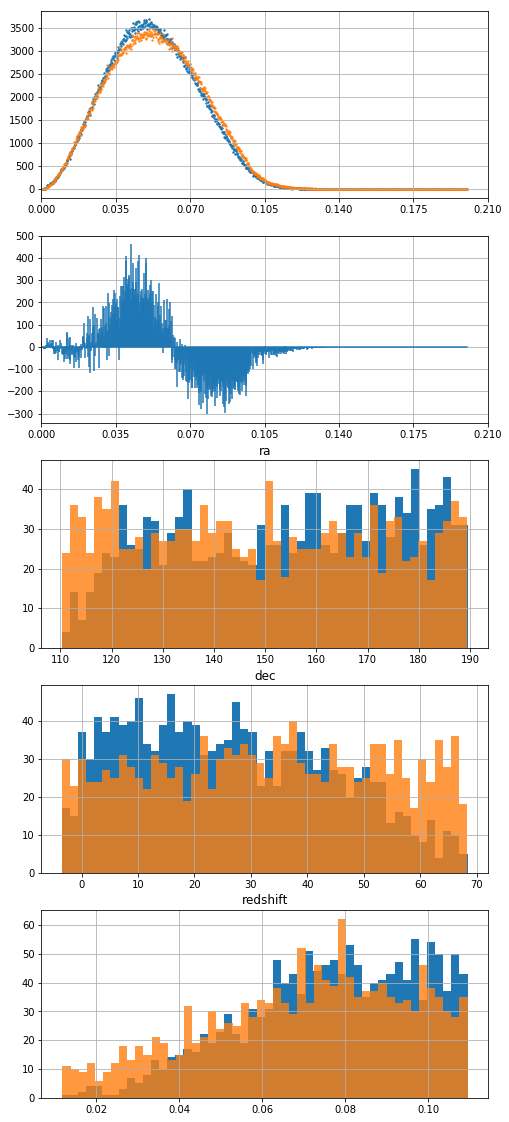

In [255]:
plot_results(centers_by_labels(to_xyz(subareas[0]), res[0]), 1000, 0.2, 4)

In [253]:
?plot_results

In [205]:
a = np.load('mean_time.npy')

In [213]:
dbscan = DBSCAN(eps=0.00107, min_samples=12).fit(to_xyz(subareas[0]))
res = np.unique(dbscan.labels_, return_counts=True)

In [209]:
(a/60.)[0]

array([  5.79937708,   5.83045775,   8.37212145,  14.35248227,
        25.42182373,  56.51284661,  71.05190487,  14.23526158])

In [214]:
res

(array([  -1,    0,    1, ..., 1412, 1413, 1414], dtype=int64),
 array([79884,    16,    12, ...,    12,    12,     7], dtype=int64))

In [217]:
Г = 0
for a in res[1][1:]:
    if a > 60:
        Г += 1
        print(a)
print('\n', Г)

25284
198
80
74
67
61
1029
188
63
176
525
2081
63
232
118
104
92
7548
77
86
76
1346
893
70
117
73
380
61
93
224
138
108
77
63
513
153
61
98
332
185
358
71
645
72
105
388
64
89
221
65
330
361
169
81
454
63
67
88
99
417
604
78
213
106
62
166
71
61
73
190
83
164
74
82
309
127
1117
105
106
61
144
112
92
80
262
392
61
77
72
127
63
67
76
78
210
146
67
2818
78
99
99
129
414
100
116
139
87
79
74
443
174
87
136
83
154
1129
243
72
359
82
117
146
98
63
154
72
558
143
85
64
106
150
93
187
117
178
112
69
87
67
73
111
90
140
136
69
1244
271
182
71
101
567
425
110
246
375
85
267
72
81
194
242
69
2524
255
171
128
96
120
113
92
189
68
2256
73
988
63
86
66
446
81
77
422
68
500
191
159
282
98
155
497
97
198
198
100
355
105
110
64
606
82
70
240
231
70
175
196
94
326
107
73
91
61
73
165
283
322
108
97
85
265
73
80
65

 224


In [108]:
result.x[0]

0.00074422738126829512

In [109]:
result.x[1]

16.464255769649128

In [84]:
def centers_by_labels(points_xyz, labels):
    all_labels = np.unique(labels)
    cen_clusters = list()
    for lab in all_labels[1:]: #don't need noize
        cen_clusters.append(points_xyz[labels==lab].mean(axis=0))
        
    return np.array(cen_clusters)
        

In [86]:
?plot_results

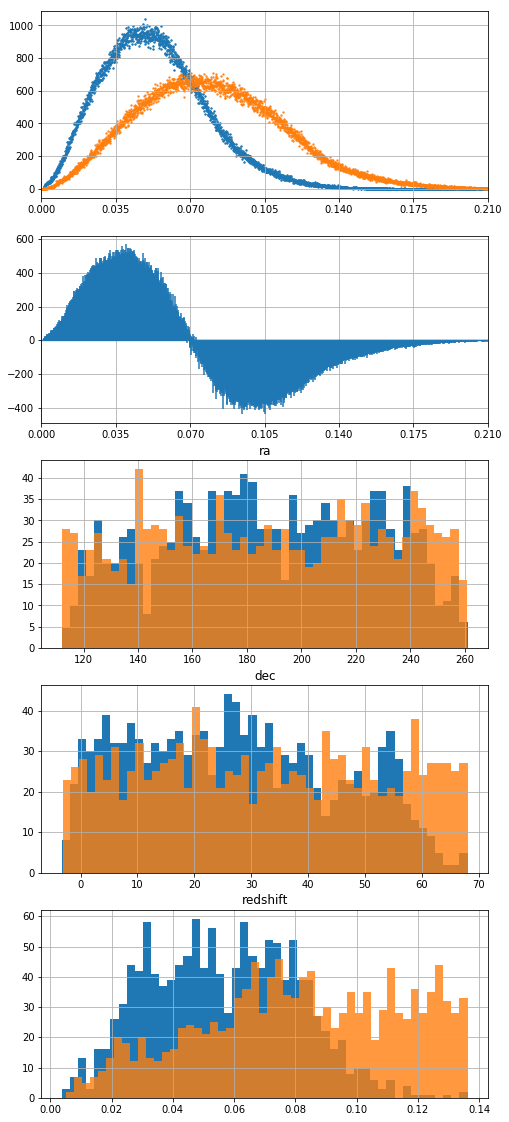

In [118]:
plot_results(centers_by_labels(xyz_left_area, dbscan.labels_), 3000, 0.21, mod_mix=4)

In [78]:
?plot_results

In [16]:
start_time = time()
mean_shift = MeanShift(bin_seeding=True, cluster_all=False, min_bin_freq=2)
res_mean_shift = mean_shift.fit_predict(to_xyz(
    left_area[(left_area[:,2] > 0.15) & (left_area[:,0] < 186)]))
mean_sh_time = time() - start_time
print(max(res_mean_shift), mean_sh_time)

0 1165.2401983737946


In [41]:
res_mean_shift[res_mean_shift==0].shape

(71294,)

In [15]:
start_time = time()
mean_shift = MeanShift(bin_seeding=True, cluster_all=False, bandwidth=0.003, min_bin_freq=2)
res_mean_shift_3 = mean_shift.fit_predict(to_xyz(
    left_area[(left_area[:,2] > 0.15) & (left_area[:,0] < 186)]))
mean_sh_time_3 = time() - start_time
print(max(res_mean_shift_3), mean_sh_time_3)

11840 68.12590479850769


In [12]:
start_time = time()
mean_shift = MeanShift(bin_seeding=True, cluster_all=False, bandwidth=0.001, min_bin_freq=2)
res_mean_shift_2 = mean_shift.fit_predict(to_xyz(
    left_area[(left_area[:,2] > 0.15) & (left_area[:,0] < 186)]))
mean_sh_time_2 = time() - start_time
print(max(res_mean_shift_2), mean_sh_time_2)

8559 18.568346977233887


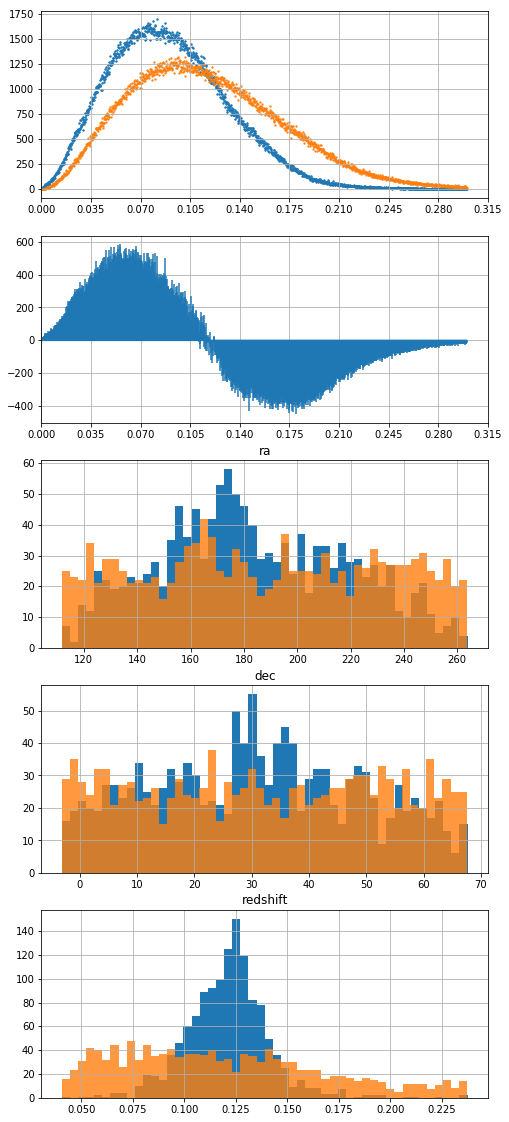

In [49]:
plot_results(tmp1, 1500, 0.3, mod_mix=4)

In [14]:
np.unique(res_mean_shift_2, return_counts=True)

(array([  -1,    0,    1, ..., 8557, 8558, 8559]),
 array([89631,    20,    15, ...,     2,     2,     2], dtype=int64))

In [9]:
np.unique(dbscan.labels_, return_counts=True)

(array([  -1,    0,    1, ..., 6129, 6130, 6131], dtype=int64),
 array([74714,     9,    25, ...,     8,     7,     5], dtype=int64))

In [69]:
(dbscan.labels_==0).sum()

5

In [66]:
max(dbscan.labels_)

0

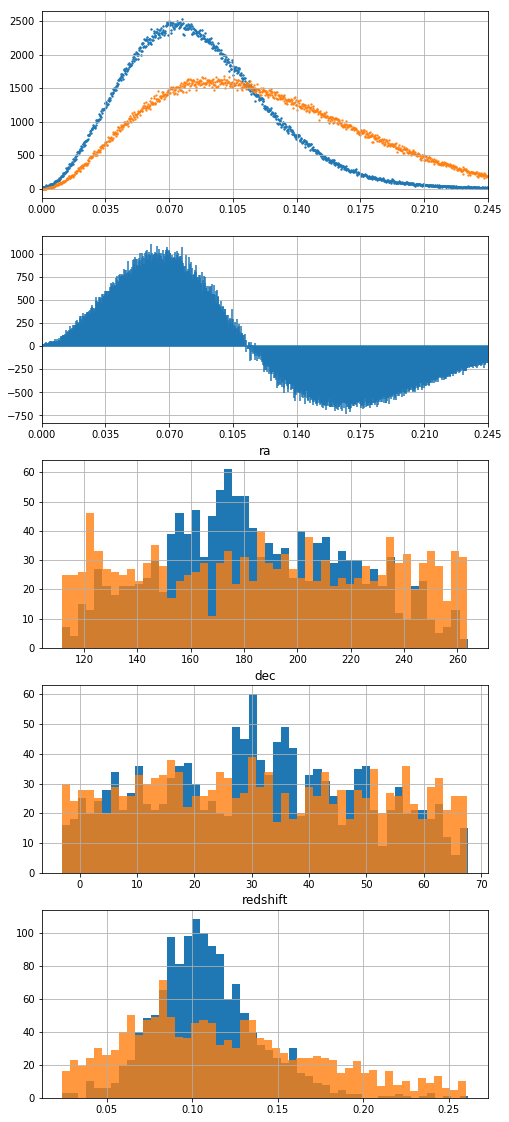

In [973]:
plot_results(tmp, 1000, 0.245, mod_mix=4)

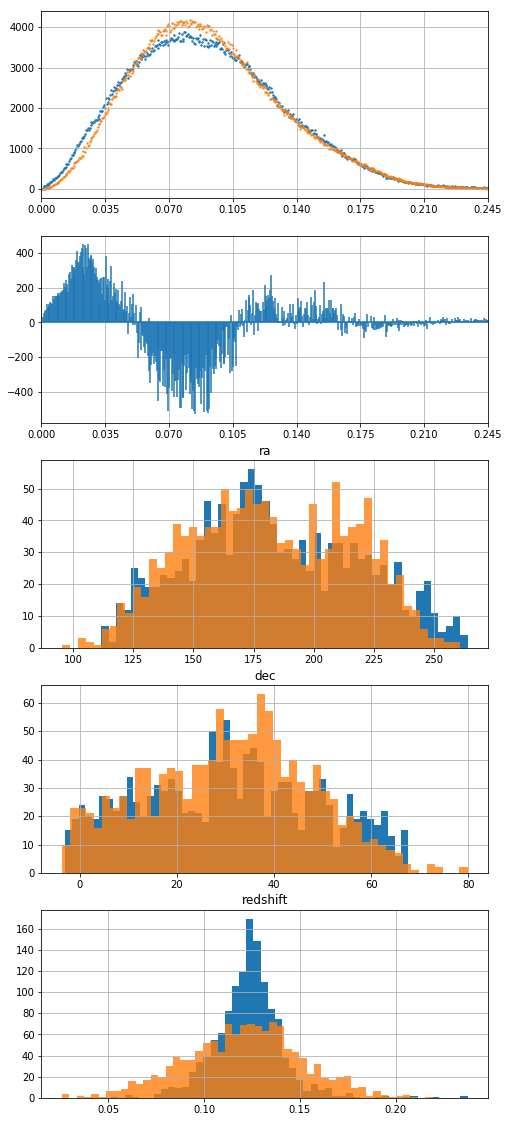

In [964]:
plot_results(arr_cl_dummy, 500, 0.245, mod_mix=3)
#plot_results(tmp, 2000, 0.25)

In [329]:
bot_edge = 0
top_edge = 12
scale_coef = 0.0087
eps=scale_coef*10e-4
cub_struct = np.zeros(((top_edge-bot_edge)**3, 3))
noize = (np.random.random_sample(size=cub_struct.shape)-0.5) + 1

idx = 0
for i in range(bot_edge, top_edge):
    for j in range(bot_edge, top_edge):
        for k in range(bot_edge, top_edge):
            cub_struct[idx, 0] = i + eps
            cub_struct[idx, 1] = j + eps
            cub_struct[idx, 2] = k + eps
            idx+=1
            
cub_struct = cub_struct * scale_coef * noize

array=to_ra_dec_redshift(cub_struct)
ra = 0.
mask = ((array[:,0] > ra - 75.) & (array[:, 0] < ra + 75.) &
            (array[:,1] > 0.1) & (array[:,1] < 65.))
cub_struct_cutted = to_xyz(array[mask])

In [330]:
unif_cutted = uniform_distr(cub_struct, False)
array=to_ra_dec_redshift(unif_cutted)
ra = 0.
mask = ((array[:,0] > ra - 75.) & (array[:, 0] < ra + 75.) &
            (array[:,1] > 0.) & (array[:,1] < 65.))
unif_cutted = to_xyz(array[mask])

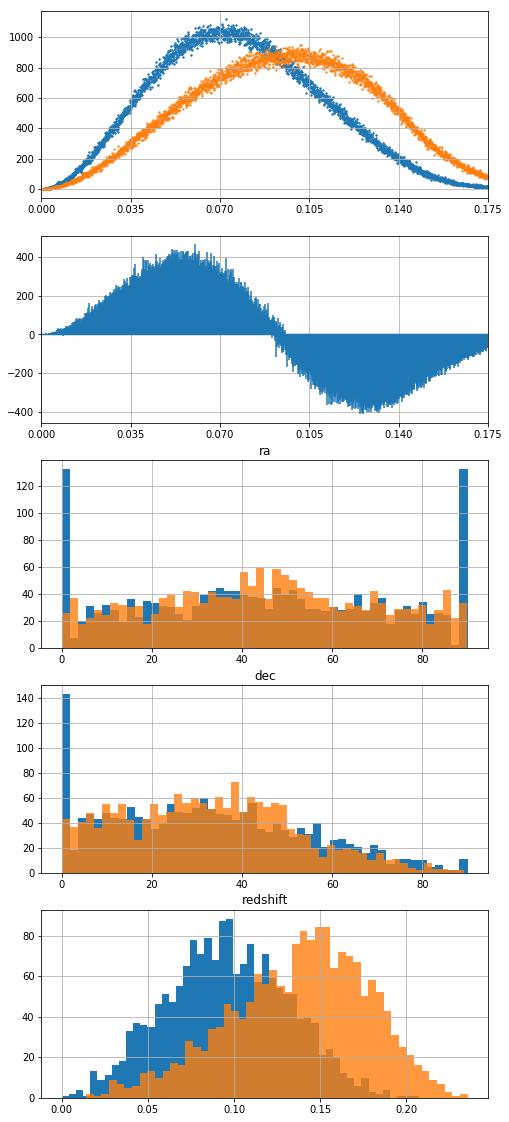

In [331]:
plot_results(cub_struct, 3000, 0.175, mod_mix=5)

In [293]:
min(cub_struct[:, 2]) / 0.035

3.0629190243193575e-05

In [286]:
uniform_distr(cub_struct, in_polar=True)

array([[ 0.11357792,  0.06215384,  0.24247759],
       [ 0.01870737,  0.01229132,  0.05923897],
       [ 0.0086103 ,  0.02576406,  0.06570405],
       ..., 
       [ 0.01953556,  0.01156802,  0.07764621],
       [-0.01038169,  0.00305078,  0.1064924 ],
       [ 0.01049375,  0.00685654,  0.0360866 ]])

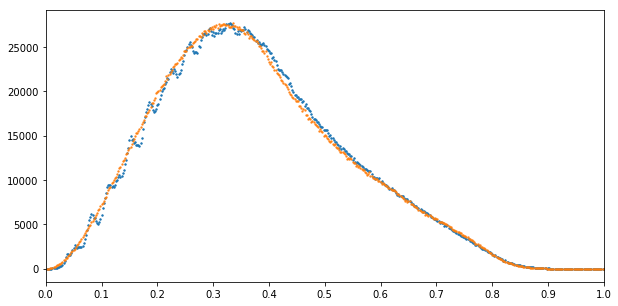

In [304]:
num_bins = 500
right_edge = 1
n1 = get_hist(cub_struct, num_bins, right_edge)           
n2 = get_hist(uniform_distr(cub_struct, in_polar=False), num_bins, right_edge)



fig = plt.figure(figsize=(10, 5))
plt.scatter(n1[1][1:], n1[0], s=2)
plt.scatter(n2[1][1:], n2[0], s=2, alpha=0.8)
plt.xlim([0, right_edge])
plt.xticks(np.linspace(0, right_edge, 11))
plt.show()

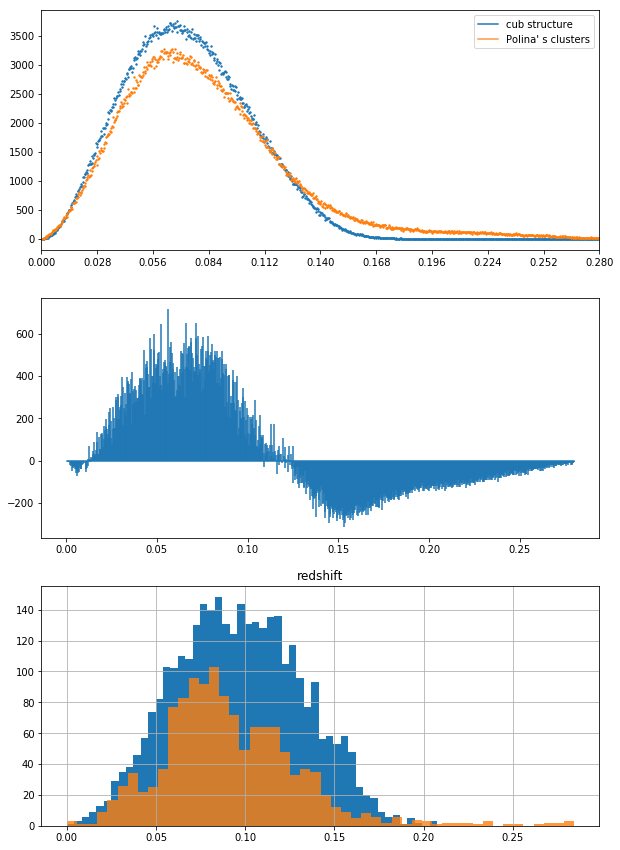

In [223]:
num_bins = 800
right_edge = 0.28
n1 = get_hist(cub_struct_cutted, num_bins, right_edge)  
n3 = get_hist(to_xyz(polina_clusters_left), num_bins, right_edge)  

fig = plt.figure(figsize=(10, 15))
plt.subplot(311)
plt.scatter(n1[1][1:], n1[0], s=2)
plt.scatter(n3[1][1:], n3[0], s=2)
plt.xlim([0, right_edge])
plt.xticks(np.linspace(0, right_edge, 11))

cub = mlines.Line2D([], [], color='C0', label='cub structure')
pol = mlines.Line2D([], [], color='C1', alpha=0.8, label="Polina' s clusters")
plt.legend(handles=[cub, pol])

#plt.show()
plt.subplot(312)
plot_distinguish(n1, n3)


plt.subplot(313)
plt.title('redshift')
plt.hist(to_ra_dec_redshift(cub_struct)[:,2], 50)
plt.hist(polina_clusters_left[:,2], 50, alpha=0.8)
plt.grid(True)
plt.show()

## Работа с кластерами Роберта

In [19]:
left_rob, right_rob = left_right_regions(robert_cl)

In [30]:
left_rob = left_rob[left_rob[:,2]>10e-4]

In [32]:
left_rob[left_rob[:,2]<0.3].shape

(9034, 3)

In [35]:
?plot_results

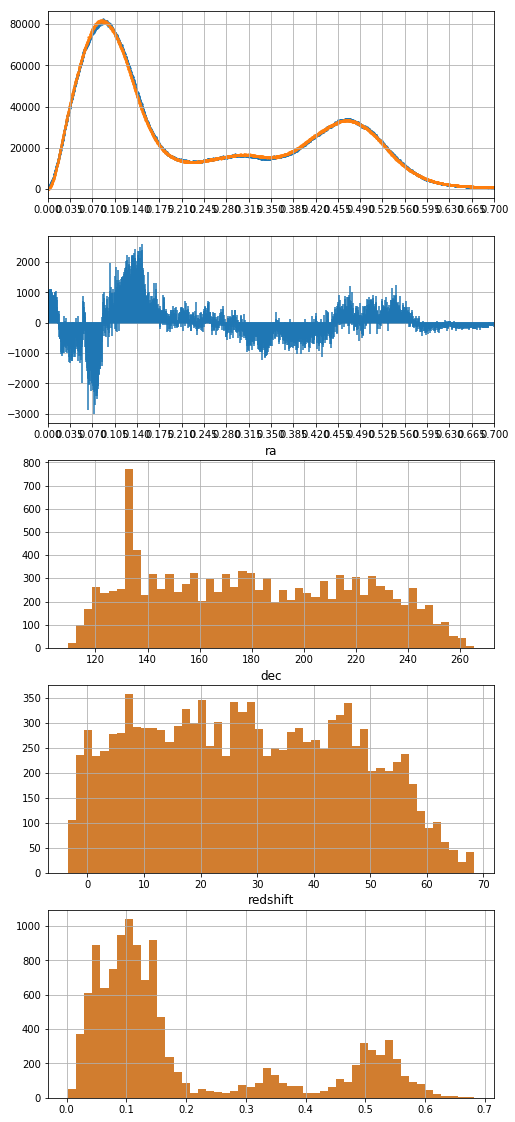

In [55]:
plot_results(to_xyz(left_rob), 3000, 0.7, mod_mix=2)

## Работа с кластерами Полины

In [8]:
polina_clusters = reader('data/Clusters Polina.txt', commos2points=True)
mask_na = np.any(np.isnan(polina_clusters), axis=1)
polina_clusters = polina_clusters[~mask_na]
polina_clusters_left, _ = left_right_regions(polina_clusters)

In [ ]:
plot_results(to_xyz(...), 1500, 0.3, mod_mix=4, save=False, name='uniform xyz')

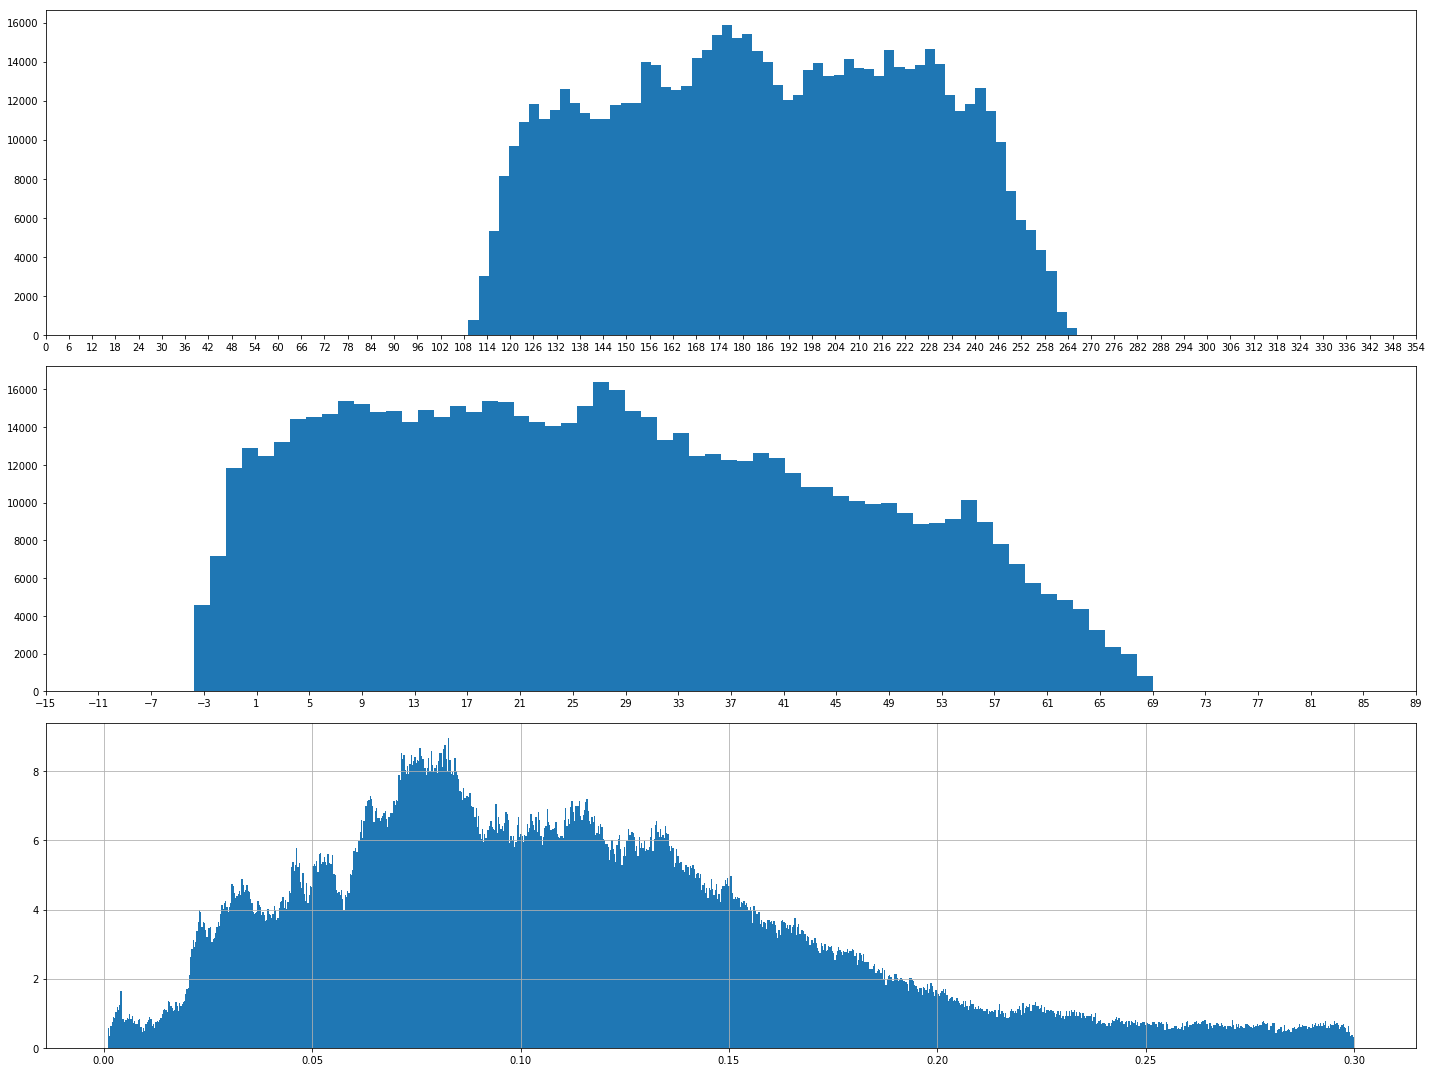

In [237]:
fig = plt.figure(figsize=(20, 15))

data = left_area[dbscan.labels_!=-1]
ax = plt.subplot(3, 1, 1)
plt.hist(data[:,0], bins=60)
plt.xticks(range(0, 360, 6))

ax = plt.subplot(3, 1, 2)
plt.hist(data[:,1], bins=60)
plt.xticks(range(-15, 90, 4))

ax = plt.subplot(3, 1, 3)
plt.hist(data[:,2], bins=1000, density=True)


#z_distr = distr_red_shift()
x = np.linspace(0, 0.7, 200)
#pdf_fitted = z_distr.pdf(x)
#plt.plot(x, pdf_fitted, color='r')
#plt.hist(z_distr.rvs(size=200000), bins=1000, density=True, alpha=0.8)
#plt.xticks(np.linspace(0, 0.3, 31))
plt.grid(True)
    
plt.tight_layout()

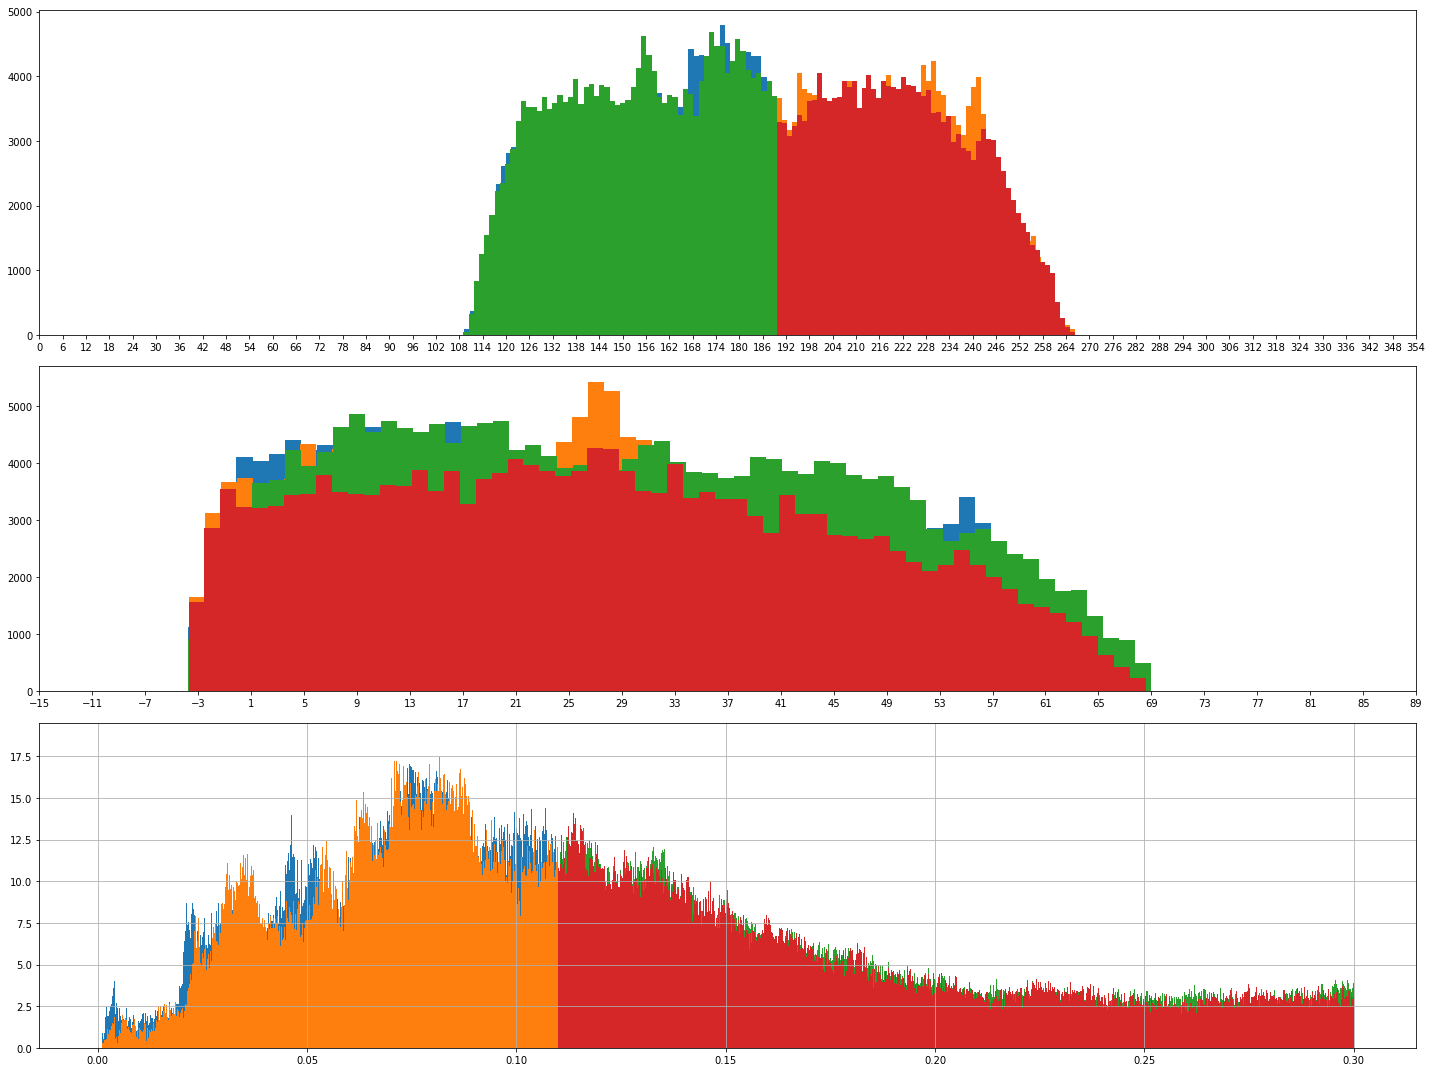

In [241]:
fig = plt.figure(figsize=(20, 15))


data_some = subareas
ax = plt.subplot(3, 1, 1)
for data in data_some:
    plt.hist(data[:,0], bins=60)
plt.xticks(range(0, 360, 6))

ax = plt.subplot(3, 1, 2)
for data in data_some:
    plt.hist(data[:,1], bins=60)
plt.xticks(range(-15, 90, 4))

ax = plt.subplot(3, 1, 3)
for data in data_some:
    plt.hist(data[:,2], bins=1000, density=True)


#z_distr = distr_red_shift()
x = np.linspace(0, 0.7, 200)
#pdf_fitted = z_distr.pdf(x)
#plt.plot(x, pdf_fitted, color='r')
#plt.hist(z_distr.rvs(size=200000), bins=1000, density=True, alpha=0.8)
#plt.xticks(np.linspace(0, 0.3, 31))
plt.grid(True)
    
plt.tight_layout()

In [14]:
def do_scan_reg(points_xyz, eps, n_neighbors,
                c_very_small=20, c_small=50, c_huge=300):
    dbscan_model = DBSCAN(eps=eps, min_samples=n_neighbors+1, metric='euclidean', algorithm='ball_tree')
    res = dbscan_model.fit_predict(points_xyz)
    lab, counts = np.unique(res, return_counts=True)
    
    noize = counts[0]
    counts = counts[1:]
    very_small = counts[counts<c_very_small].shape[0]
    small = counts[counts<c_small].shape[0] - very_small
    good = counts[(counts<c_huge) & (counts>c_small)].shape[0]
    huge = counts[counts>c_huge].shape[0]
    
    print('noize/all = {0:.3f}'.format(noize/points_xyz.shape[0]))
    print('under {0}: {1}'.format(c_very_small, very_small))
    print('under {0}: {1}'.format(c_small, small))
    print('more {0}: {1}'.format(c_huge, huge))      
    print('bigest cluster: {0}'.format(max(counts)))
    print('good clusters: {0}'.format(good))
    return res, lab, counts
    

(455, 3)
max = 1332.073
mediana = 270.73776954646416
for label 0 there are 276 galaxies
for label 2 there are 60 galaxies
for label 4 there are 35 galaxies
noize num :  (24, 3)


<IPython.core.display.Javascript object>


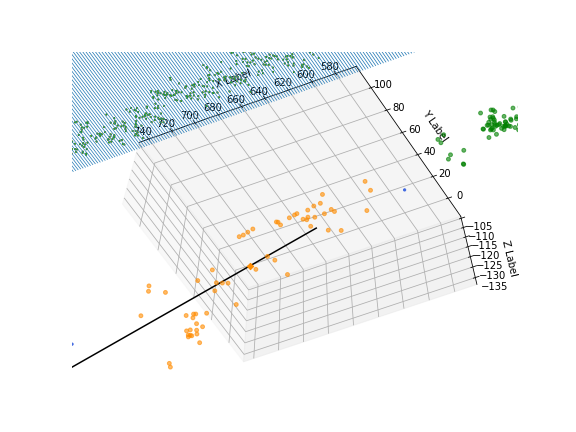

0
1
2


In [574]:
#dir_path = 'data/Abell less 0.3 chosen/'
#name_file = 'Abell_9 less 0.3 chosen.txt'

dir_path = 'data/Abell less 0.3/'
name_file = 'Abell_g_less_0.3 8.txt'

full_path = dir_path + name_file
points_xyz, ray = get_one(full_path)
print(points_xyz.shape)


pair_dist = pairwise_distances(points_xyz)
not_zero_pair = np.triu(pair_dist)
print("max = {0:.3f}".format(np.max(not_zero_pair[not_zero_pair!=0])))

med = np.median(not_zero_pair[not_zero_pair!=0])
print("mediana = {0}".format(med))

clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med/8, verbose=True)
%matplotlib notebook
fig = plt.figure(figsize=(8,6))
colours = ['royalblue', 'green', 'darkorange', 'purple']
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(0, 0, 0, c='black', s=20)
ax.plot([ray[0]/2, ray[0]], [ray[1]/2, ray[1]], [ray[2]/2, ray[2]], c='black')
for i, cluster in enumerate(clusters):
    print(i)
    if i >= 3:
        break
    ax.scatter(*(cluster.T), c=colours[i+1], s=15, alpha=0.6)
    ax.scatter((*cen_clusters[i]), c=colours[i+1], s=20, marker='D') 
ax.scatter(*(noize.T), c=colours[0], s=5, alpha=1)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.set_zticks([])
#plt.xticks([], [])
#plt.yticks([], [])

plt.axis('equal')
#plt.gca().set_aspect('equal', adjustable='box')
#ax.set_zlim(10, 500)
plt.grid('True')
plt.show()
